<a href="https://colab.research.google.com/github/miltiadiss/MSc-Thesis/blob/main/Dataset_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATASET EXPLORATION**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Explore how different acoustic features can help distinguish the different labels.

Feature Matrix Shape: (25, 452)


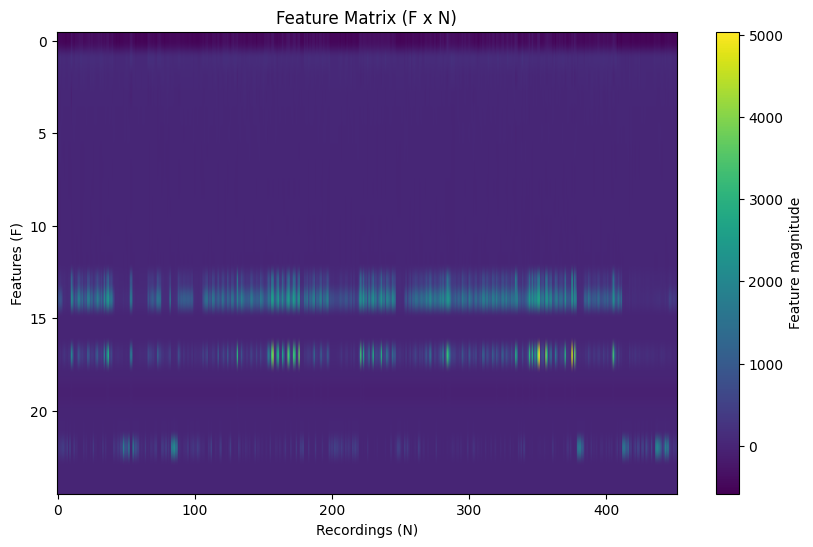

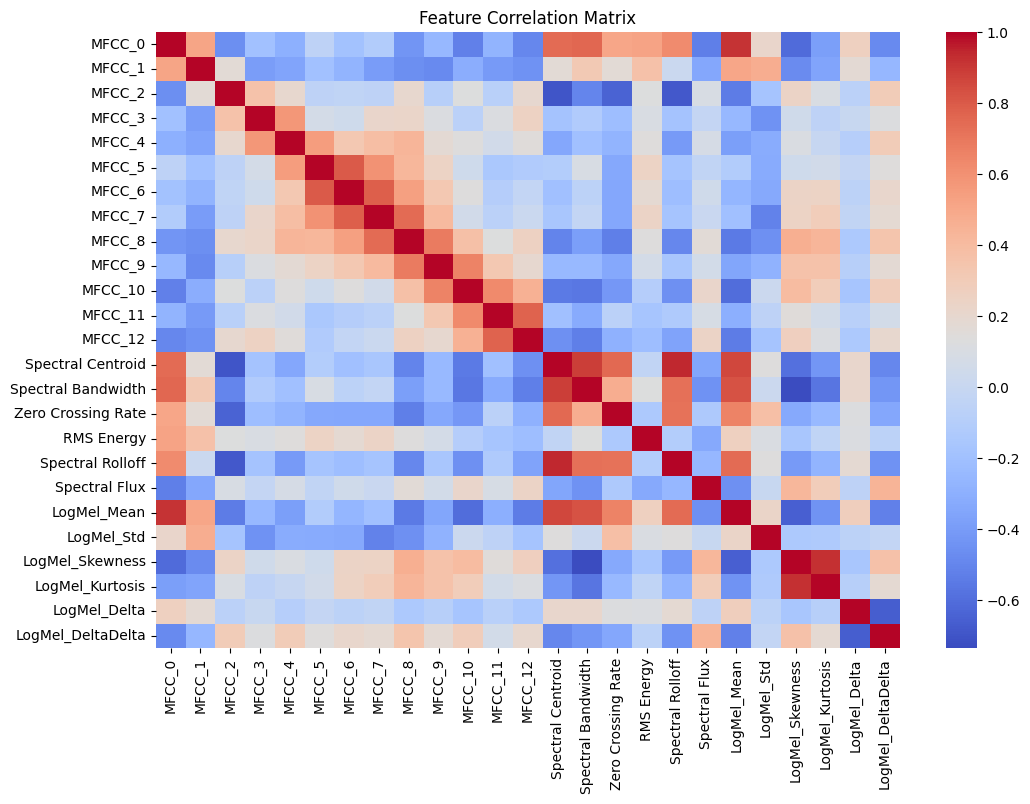

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
SAMPLING_RATE = 22050 # Resample the audio files with frequency 22.05 kHz
FRAME_LENGTH = 0.04 # Use window size of 40 ms
HOP_LENGTH = 0.02  # Use 50% overlap
N_MFCC = 13 # Extract the first 13 MFCCs
N_MELS = 64 # Use 64 Mel Banks to extract the Log-Mel Spectrograms

AUDIO_FOLDER = "/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"
ANNOTATION_FOLDER = "/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"

FEATURE_NAMES = (
    [f"MFCC_{i}" for i in range(N_MFCC)] +
    ["Spectral Centroid", "Spectral Bandwidth", "Zero Crossing Rate", "RMS Energy",
     "Spectral Rolloff", "Spectral Flux", "LogMel_Mean", "LogMel_Std",
     "LogMel_Skewness", "LogMel_Kurtosis", "LogMel_Delta", "LogMel_DeltaDelta"]
)

def get_labels(annotation_file):
    """Extract labels (Crackles, Wheezes, Both, None) from annotation file.

    Args:
        annotation_file (str): Path to annotation file (.txt).

    Returns:
        str: Label category ("Both", "Crackles", "Wheezes", or "None").
    """
    df = pd.read_csv(annotation_file, sep="\t", header=None,
                     names=["Start", "End", "Crackles", "Wheezes"])
    if df["Crackles"].sum() > 0 and df["Wheezes"].sum() > 0:
        return "Both"
    elif df["Crackles"].sum() > 0:
        return "Crackles"
    elif df["Wheezes"].sum() > 0:
        return "Wheezes"
    else:
        return "None"

def preprocess_audio(audio_path, sr=SAMPLING_RATE):
    """Load, normalize, and trim silence from audio.

    Args:
        audio_path (str): Path to audio (.wav).
        sr (int): Sampling rate.

    Returns:
        tuple: Processed audio signal (np.array), sampling rate (int).
    """
    y, sr = librosa.load(audio_path, sr=sr)
    y = librosa.util.normalize(y)
    y, _ = librosa.effects.trim(y, top_db=20)
    return y, sr

def extract_acoustic_features(audio_path):
    """Extract acoustic features from audio.

    Args:
        audio_path (str): Path to audio (.wav).

    Returns:
        np.array: 1D array of extracted features.
    """
    y, sr = preprocess_audio(audio_path)
    frame_size = int(FRAME_LENGTH * sr) # Frame size is 882 (40 ms x 22.05 kHz)
    hop_size = int(HOP_LENGTH * sr) # Hop size is 441 (20 ms x 22.05 kHz)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=frame_size, hop_length=hop_size)

    # Extract spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_size, hop_length=hop_size)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=frame_size, hop_length=hop_size)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=frame_size, hop_length=hop_size)
    spectral_flux = np.diff(spectral_centroid, axis=1)
    spectral_flux = np.hstack([spectral_flux, spectral_flux[:, -1:]])

    # Extract temporal features
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y, frame_length=frame_size, hop_length=hop_size)
    rms = librosa.feature.rms(y=y, frame_length=frame_size, hop_length=hop_size)

    # Compute Log-Mel Spectrograms
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_size, hop_length=hop_size, n_mels=N_MELS)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Compute statistical features for Log-Mel Spectrograms
    log_mel_mean = np.mean(log_mel_spectrogram, axis=1)
    log_mel_std = np.std(log_mel_spectrogram, axis=1)
    log_mel_skewness = np.mean((log_mel_spectrogram - log_mel_mean[:, None])**3, axis=1) / (log_mel_std**3 + 1e-8)
    log_mel_kurtosis = np.mean((log_mel_spectrogram - log_mel_mean[:, None])**4, axis=1) / (log_mel_std**4 + 1e-8)
    log_mel_delta = np.mean(librosa.feature.delta(log_mel_spectrogram), axis=1)
    log_mel_delta_delta = np.mean(librosa.feature.delta(log_mel_spectrogram, order=2), axis=1)

    # Aggregate features by taking the mean over time frames to create one column vector for each recording
    feature_vector = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(spectral_centroid), np.mean(spectral_bandwidth),
        np.mean(zero_crossing_rate), np.mean(rms),
        np.mean(spectral_rolloff), np.mean(spectral_flux),
        np.mean(log_mel_mean), np.mean(log_mel_std),
        np.mean(log_mel_skewness), np.mean(log_mel_kurtosis),
        np.mean(log_mel_delta), np.mean(log_mel_delta_delta)
    ])

    return feature_vector

def build_feature_matrix():
    """Create feature matrix from audio dataset.

    Returns:
        tuple: DataFrame of features, list of labels.
    """
    all_features, labels = [], []
    annotation_labels = {f.replace(".txt", ".wav"): get_labels(os.path.join(ANNOTATION_FOLDER, f))
                         for f in os.listdir(ANNOTATION_FOLDER) if f.endswith(".txt")}

    for f in sorted(os.listdir(AUDIO_FOLDER)):
        if f.endswith(".wav"):
            path = os.path.join(AUDIO_FOLDER, f)
            # Extract the feature vector for every recording
            feature_vector = extract_acoustic_features(path)

            if len(feature_vector) != len(FEATURE_NAMES):
                print(f"Warning: Mismatch in {f}")
                continue
            # Aggragate all the feature vectors of the recordings to form the feature matrix (V)
            all_features.append(feature_vector)
            # Aggreagate all the different labels from the annotation files
            labels.append(annotation_labels.get(f, "Unknown"))

    df_features = pd.DataFrame(all_features, columns=FEATURE_NAMES)
    return df_features, labels

# Execute feature extraction
feature_matrix_V, labels = build_feature_matrix()
print(f"Feature Matrix Shape: {feature_matrix_V.T.shape}")

# Feature Matrix (Features (F) x Recordings(N)) Heatmap
plt.figure(figsize=(10, 6))
plt.imshow(feature_matrix_V.T, aspect='auto', cmap='viridis')
plt.xlabel("Recordings (N)")
plt.ylabel("Features (F)")
plt.title("Feature Matrix (F x N)")
plt.colorbar(label="Feature magnitude")
plt.show()

# Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(feature_matrix_V.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

Check the distributions of the features across all the recordings to observe which contribute the least information. Also plot the boxplots.

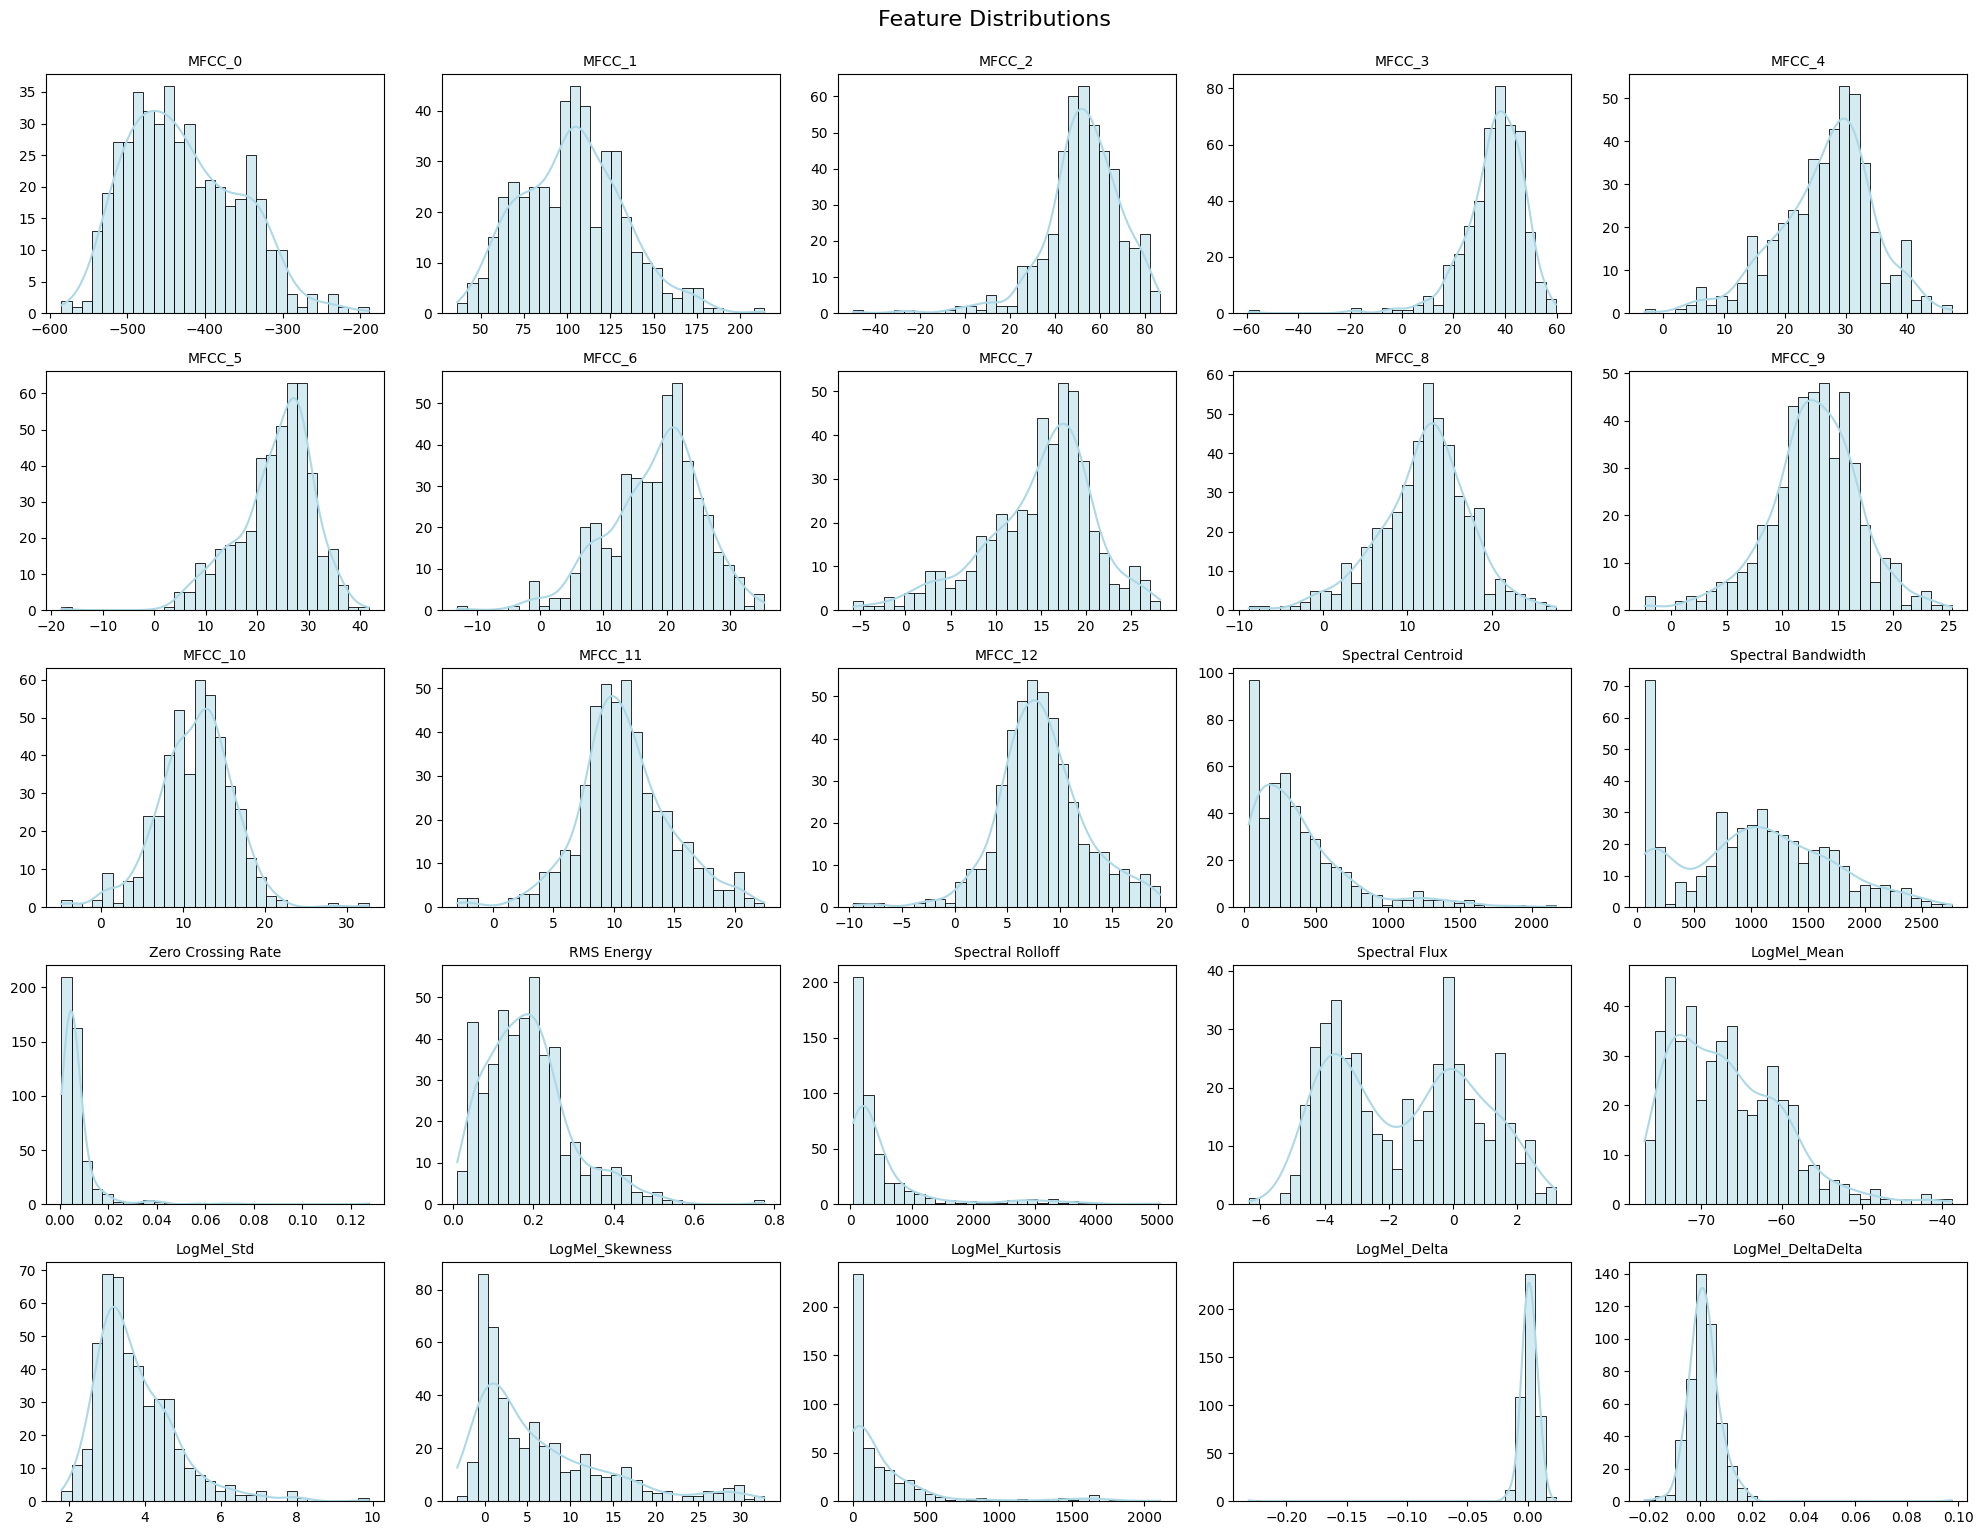

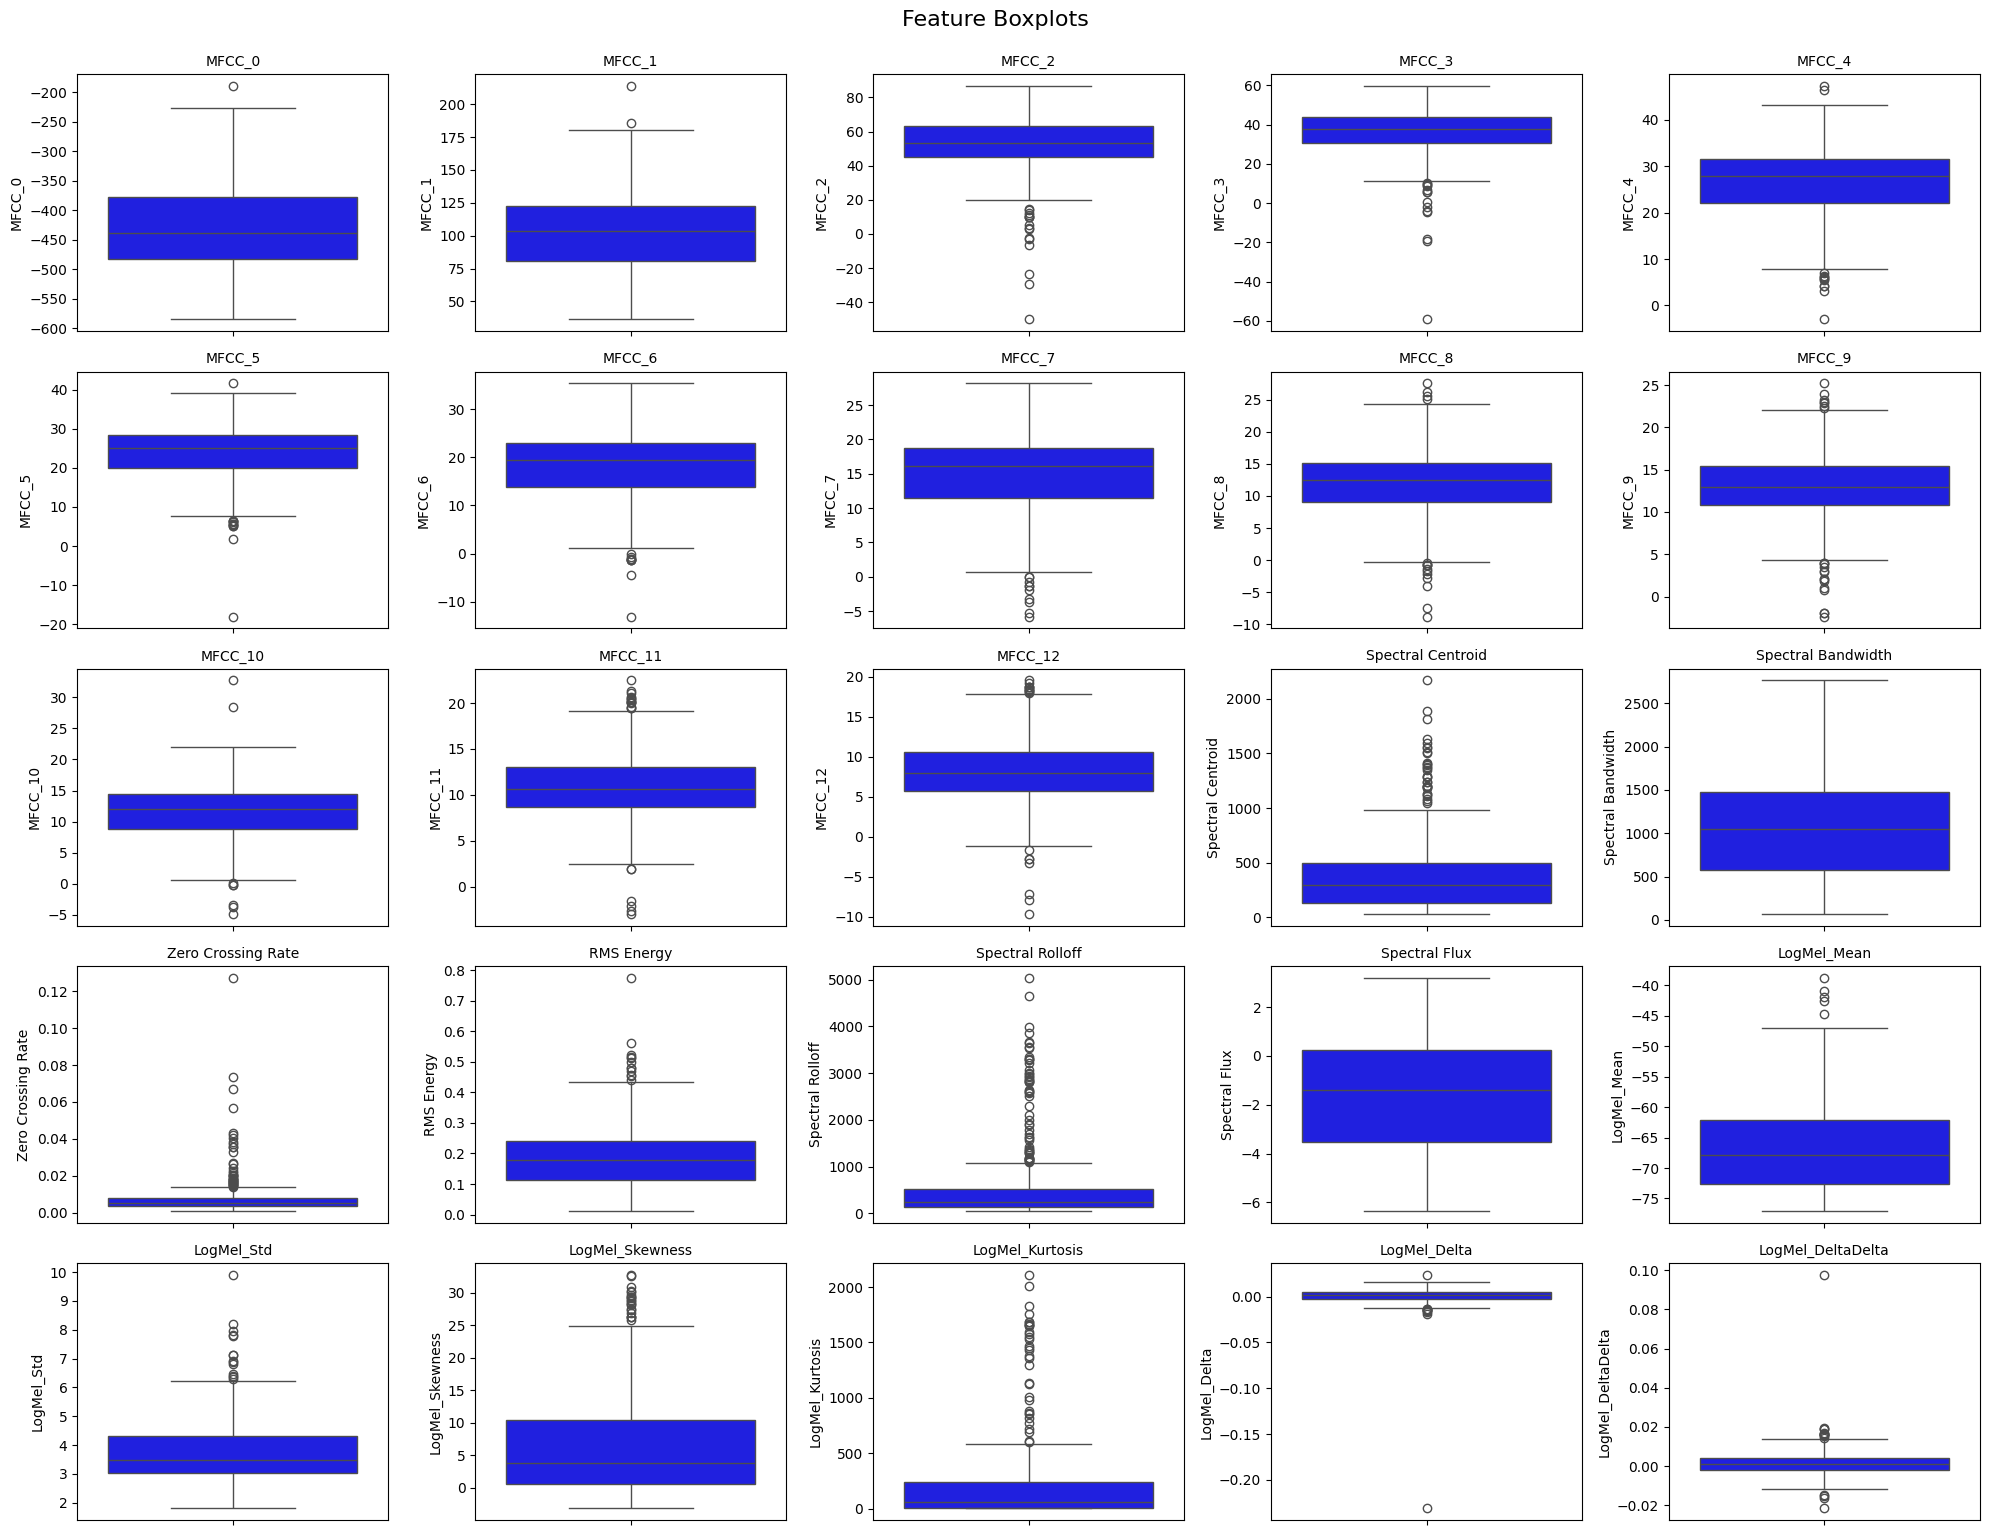

In [ ]:
def plot_feature_distributions(feature_matrix, feature_names, rows=5, cols=5):
    """Plot histograms of feature distributions in a grid.

    Args:
        feature_matrix (pd.DataFrame): DataFrame containing features.
        feature_names (list): List of feature names to plot.
        rows (int): Number of rows in the plot grid.
        cols (int): Number of columns in the plot grid.

    Returns:
        None: Displays histogram plots.
    """
    num_plots = rows * cols
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(feature_names[:num_plots]):
        plt.subplot(rows, cols, i + 1)
        sns.histplot(feature_matrix[feature], kde=True, bins=30, color="lightblue")
        plt.title(feature, fontsize=10)
        plt.xlabel("")
        plt.ylabel("")
    plt.tight_layout()
    plt.suptitle("Feature Distributions", fontsize=16, y=1.02)
    plt.show()

def plot_feature_boxplots(feature_matrix, feature_names, rows=5, cols=5):
    """Plot boxplots of features in a grid.

    Args:
        feature_matrix (pd.DataFrame): DataFrame containing features.
        feature_names (list): List of feature names to plot.
        rows (int): Number of rows in the plot grid.
        cols (int): Number of columns in the plot grid.

    Returns:
        None: Displays boxplot plots.
    """
    num_plots = rows * cols
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(feature_names[:num_plots]):
        plt.subplot(rows, cols, i + 1)
        sns.boxplot(y=feature_matrix[feature], color="blue")
        plt.title(feature, fontsize=10)
        plt.xlabel("")
    plt.tight_layout()
    plt.suptitle("Feature Boxplots", fontsize=16, y=1.02)
    plt.show()

# Execute plotting functions
plot_feature_distributions(feature_matrix_V, FEATURE_NAMES)
plot_feature_boxplots(feature_matrix_V, FEATURE_NAMES)

**MFCC_5 and MFCC_6** have very similar distribution shapes, centered around similar mean values and dispersions.

**MFCC_7 and MFCC_8** also exhibit nearly identical shapes and distributions.

**MFCC_10, MFCC_11, and MFCC_12** have highly similar Gaussian-like distributions, making them somewhat redundant.

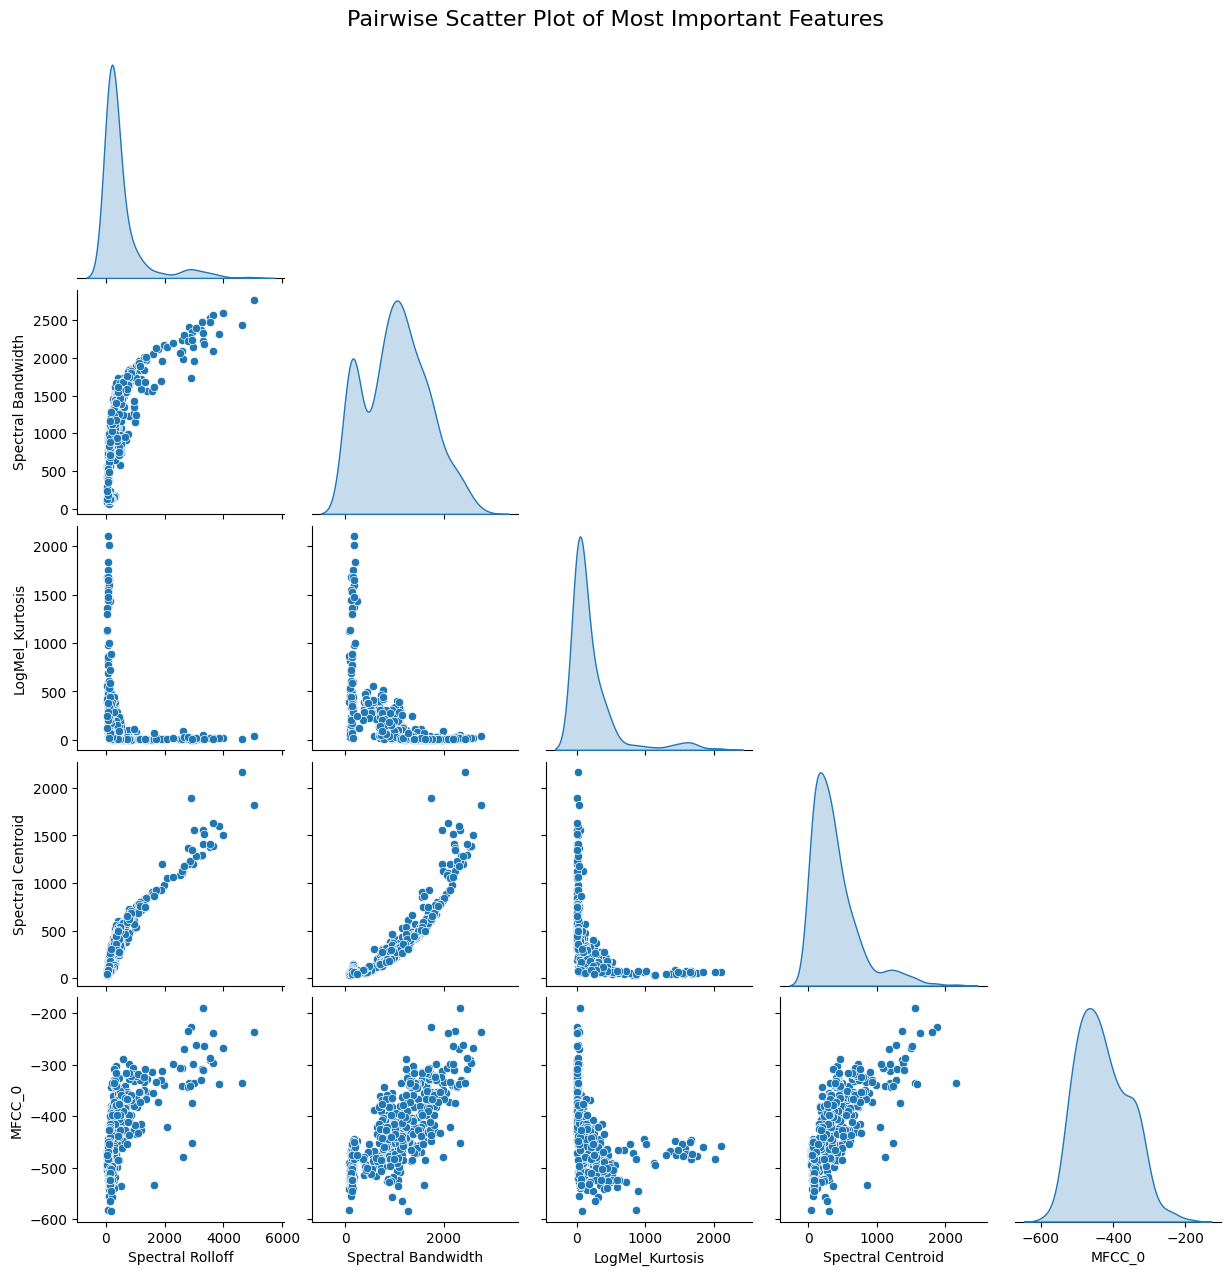

In [ ]:
def plot_pairwise_scatter(feature_matrix, top_n=5):
    """Plot pairwise scatter plots of the most varying features.

    This function selects features with the highest standard deviation and plots their pairwise relationships.

    Args:
        feature_matrix (pd.DataFrame): DataFrame containing extracted features.
        top_n (int, optional): Number of top features by standard deviation to plot. Defaults to 5.

    Returns:
        None: Displays the pairwise scatter plot figure.
    """
    # Select top_n features based on standard deviation
    top_features = feature_matrix.std().sort_values(ascending=False).index[:top_n]

    sns.pairplot(feature_matrix[top_features], diag_kind="kde", corner=True)
    plt.suptitle("Pairwise Scatter Plot of Most Important Features", fontsize=16, y=1.02)
    plt.show()

# Execute the pairwise scatter plot function
plot_pairwise_scatter(feature_matrix_V, top_n=5)

**Features to Remove**:

**LogMel_Delta, LogMel_DeltaDelta** → Minimal contribution in PCA and t-SNE, and their distributions are highly similar.

**MFCCs (MFCC_3, MFCC_4, MFCC_10, MFCC_11, MFCC_12)** → Low ranking in both PCA and t-SNE.

**Zero Crossing Rate** → Has minimal impact in feature contributions.

**Spectral Flux** → Does not contribute significantly.

In [ ]:
# Unnecessary features to remove from feature matrix that don't provide any further information
features_to_remove = [
    "LogMel_Delta", "LogMel_DeltaDelta", "MFCC_3", "MFCC_4", "MFCC_10",
    "MFCC_11", "MFCC_12", "Zero Crossing Rate", "Spectral Flux"
]

# Remove these features from the feature matrix
filtered_feature_matrix_V = feature_matrix_V.drop(columns=features_to_remove)

# Display shape after removal
print(f"Original feature matrix shape: {feature_matrix_V.T.shape}")
print(f"Filtered feature matrix shape: {filtered_feature_matrix_V.T.shape}")

Original feature matrix shape: (25, 452)
Filtered feature matrix shape: (16, 452)


Now check which of the influential features separate the best the different labels.

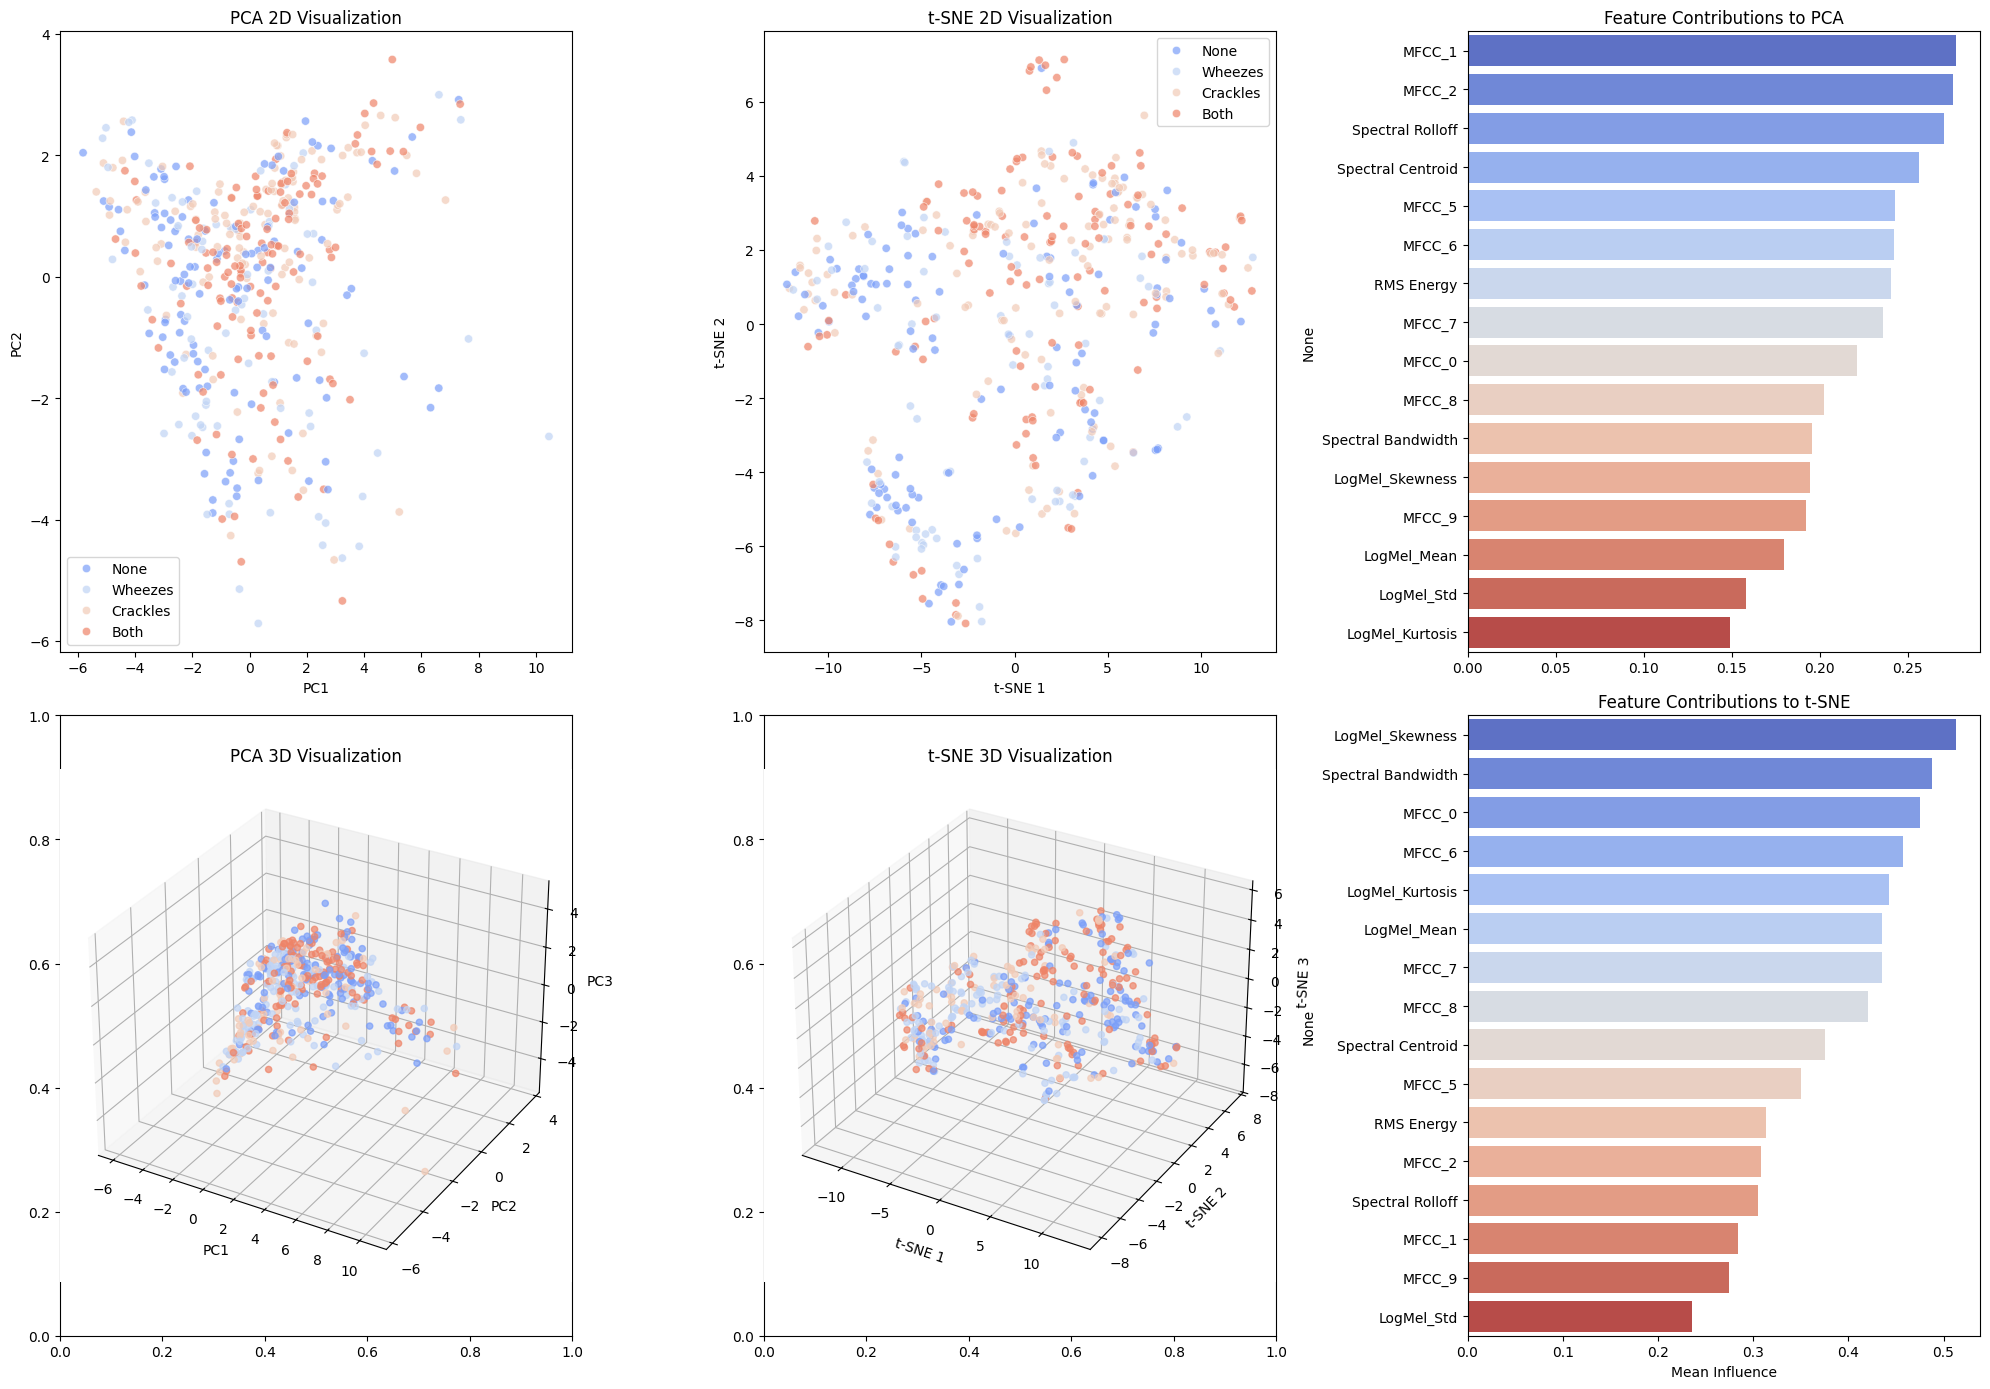

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

def perform_pca_and_tsne(feature_matrix, labels, pca_components=15, tsne_components=3, perplexity=30):
    """Perform PCA and t-SNE visualization along with feature importance plots.

    Args:
        feature_matrix (pd.DataFrame): The input feature matrix (samples × features).
        labels (list or array): Labels corresponding to each sample.
        pca_components (int, optional): Number of PCA components. Defaults to 15.
        tsne_components (int, optional): Number of t-SNE components. Defaults to 3.
        perplexity (int, optional): Perplexity parameter for t-SNE. Defaults to 30.

    Returns:
        None: Displays PCA/t-SNE visualizations and feature importance plots.
    """
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

    # PCA
    pca = PCA(n_components=pca_components)
    pca_result = pca.fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_components)])
    pca_df["Label"] = labels

    # t-SNE
    tsne = TSNE(n_components=tsne_components, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)
    tsne_df = pd.DataFrame(tsne_result, columns=[f"t-SNE {i+1}" for i in range(tsne_components)])
    tsne_df["Label"] = labels

    # PCA Feature Importance
    pca_feature_importance = pd.DataFrame(
        np.abs(pca.components_[:3]), columns=feature_matrix.columns
    ).mean(axis=0).sort_values(ascending=False)

    # t-SNE Feature Importance
    correlation_matrix = np.corrcoef(scaled_features.T, tsne_result.T)
    tsne_feature_importance = pd.DataFrame(
        np.abs(correlation_matrix[:len(feature_matrix.columns), len(feature_matrix.columns):]),
        index=feature_matrix.columns,
        columns=[f"t-SNE {i+1}" for i in range(tsne_components)]
    )
    tsne_feature_importance["Mean Influence"] = tsne_feature_importance.mean(axis=1)
    tsne_feature_importance.sort_values(by="Mean Influence", ascending=False, inplace=True)

    # Visualization Setup
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))

    palette = sns.color_palette("coolwarm", len(set(labels)))
    label_mapping = {label: palette[i] for i, label in enumerate(set(labels))}
    colors_pca = [label_mapping[label] for label in labels]
    colors_tsne = [label_mapping[label] for label in labels]

    # PCA 2D Scatter
    sns.scatterplot(ax=axes[0, 0], x=pca_df["PC1"], y=pca_df["PC2"], hue=labels, palette=palette, alpha=0.7)
    axes[0, 0].set_title("PCA 2D Visualization")

    # t-SNE 2D Scatter
    sns.scatterplot(ax=axes[0, 1], x=tsne_df["t-SNE 1"], y=tsne_df["t-SNE 2"], hue=labels, palette=palette, alpha=0.7)
    axes[0, 1].set_title("t-SNE 2D Visualization")

    # PCA Feature Importance
    sns.barplot(ax=axes[0, 2], x=pca_feature_importance.values, y=pca_feature_importance.index, palette="coolwarm")
    axes[0, 2].set_title("Feature Contributions to PCA")

    # PCA 3D Scatter
    ax_pca_3d = fig.add_subplot(2, 3, 4, projection='3d')
    ax_pca_3d.scatter(pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], c=colors_pca, alpha=0.7)
    ax_pca_3d.set_xlabel("PC1")
    ax_pca_3d.set_ylabel("PC2")
    ax_pca_3d.set_zlabel("PC3")
    ax_pca_3d.set_title("PCA 3D Visualization")

    # t-SNE 3D Scatter
    ax_tsne_3d = fig.add_subplot(2, 3, 5, projection='3d')
    ax_tsne_3d.scatter(tsne_df["t-SNE 1"], tsne_df["t-SNE 2"], tsne_df["t-SNE 3"], c=colors_tsne, alpha=0.7)
    ax_tsne_3d.set_xlabel("t-SNE 1")
    ax_tsne_3d.set_ylabel("t-SNE 2")
    ax_tsne_3d.set_zlabel("t-SNE 3")
    ax_tsne_3d.set_title("t-SNE 3D Visualization")

    # t-SNE Feature Importance
    sns.barplot(ax=axes[1, 2], x=tsne_feature_importance["Mean Influence"], y=tsne_feature_importance.index, palette="coolwarm")
    axes[1, 2].set_title("Feature Contributions to t-SNE")

    plt.tight_layout()
    plt.show()

# Execute PCA and t-SNE visualization function
perform_pca_and_tsne(filtered_feature_matrix_V, labels)

**t-SNE offers much better separation than PCA** in 3D. This indicates that the **data has non-linear relationships** that t-SNE is capturing, which PCA could not.

**Crackles & Both** → More influenced by **MFCCs, Spectral Centroid, Rolloff**.

**Wheezes** → More influenced by **Spectral Bandwidth & LogMel-based features**.

**None** → **Less variance in all spectral features**, meaning a more uniform sound pattern.

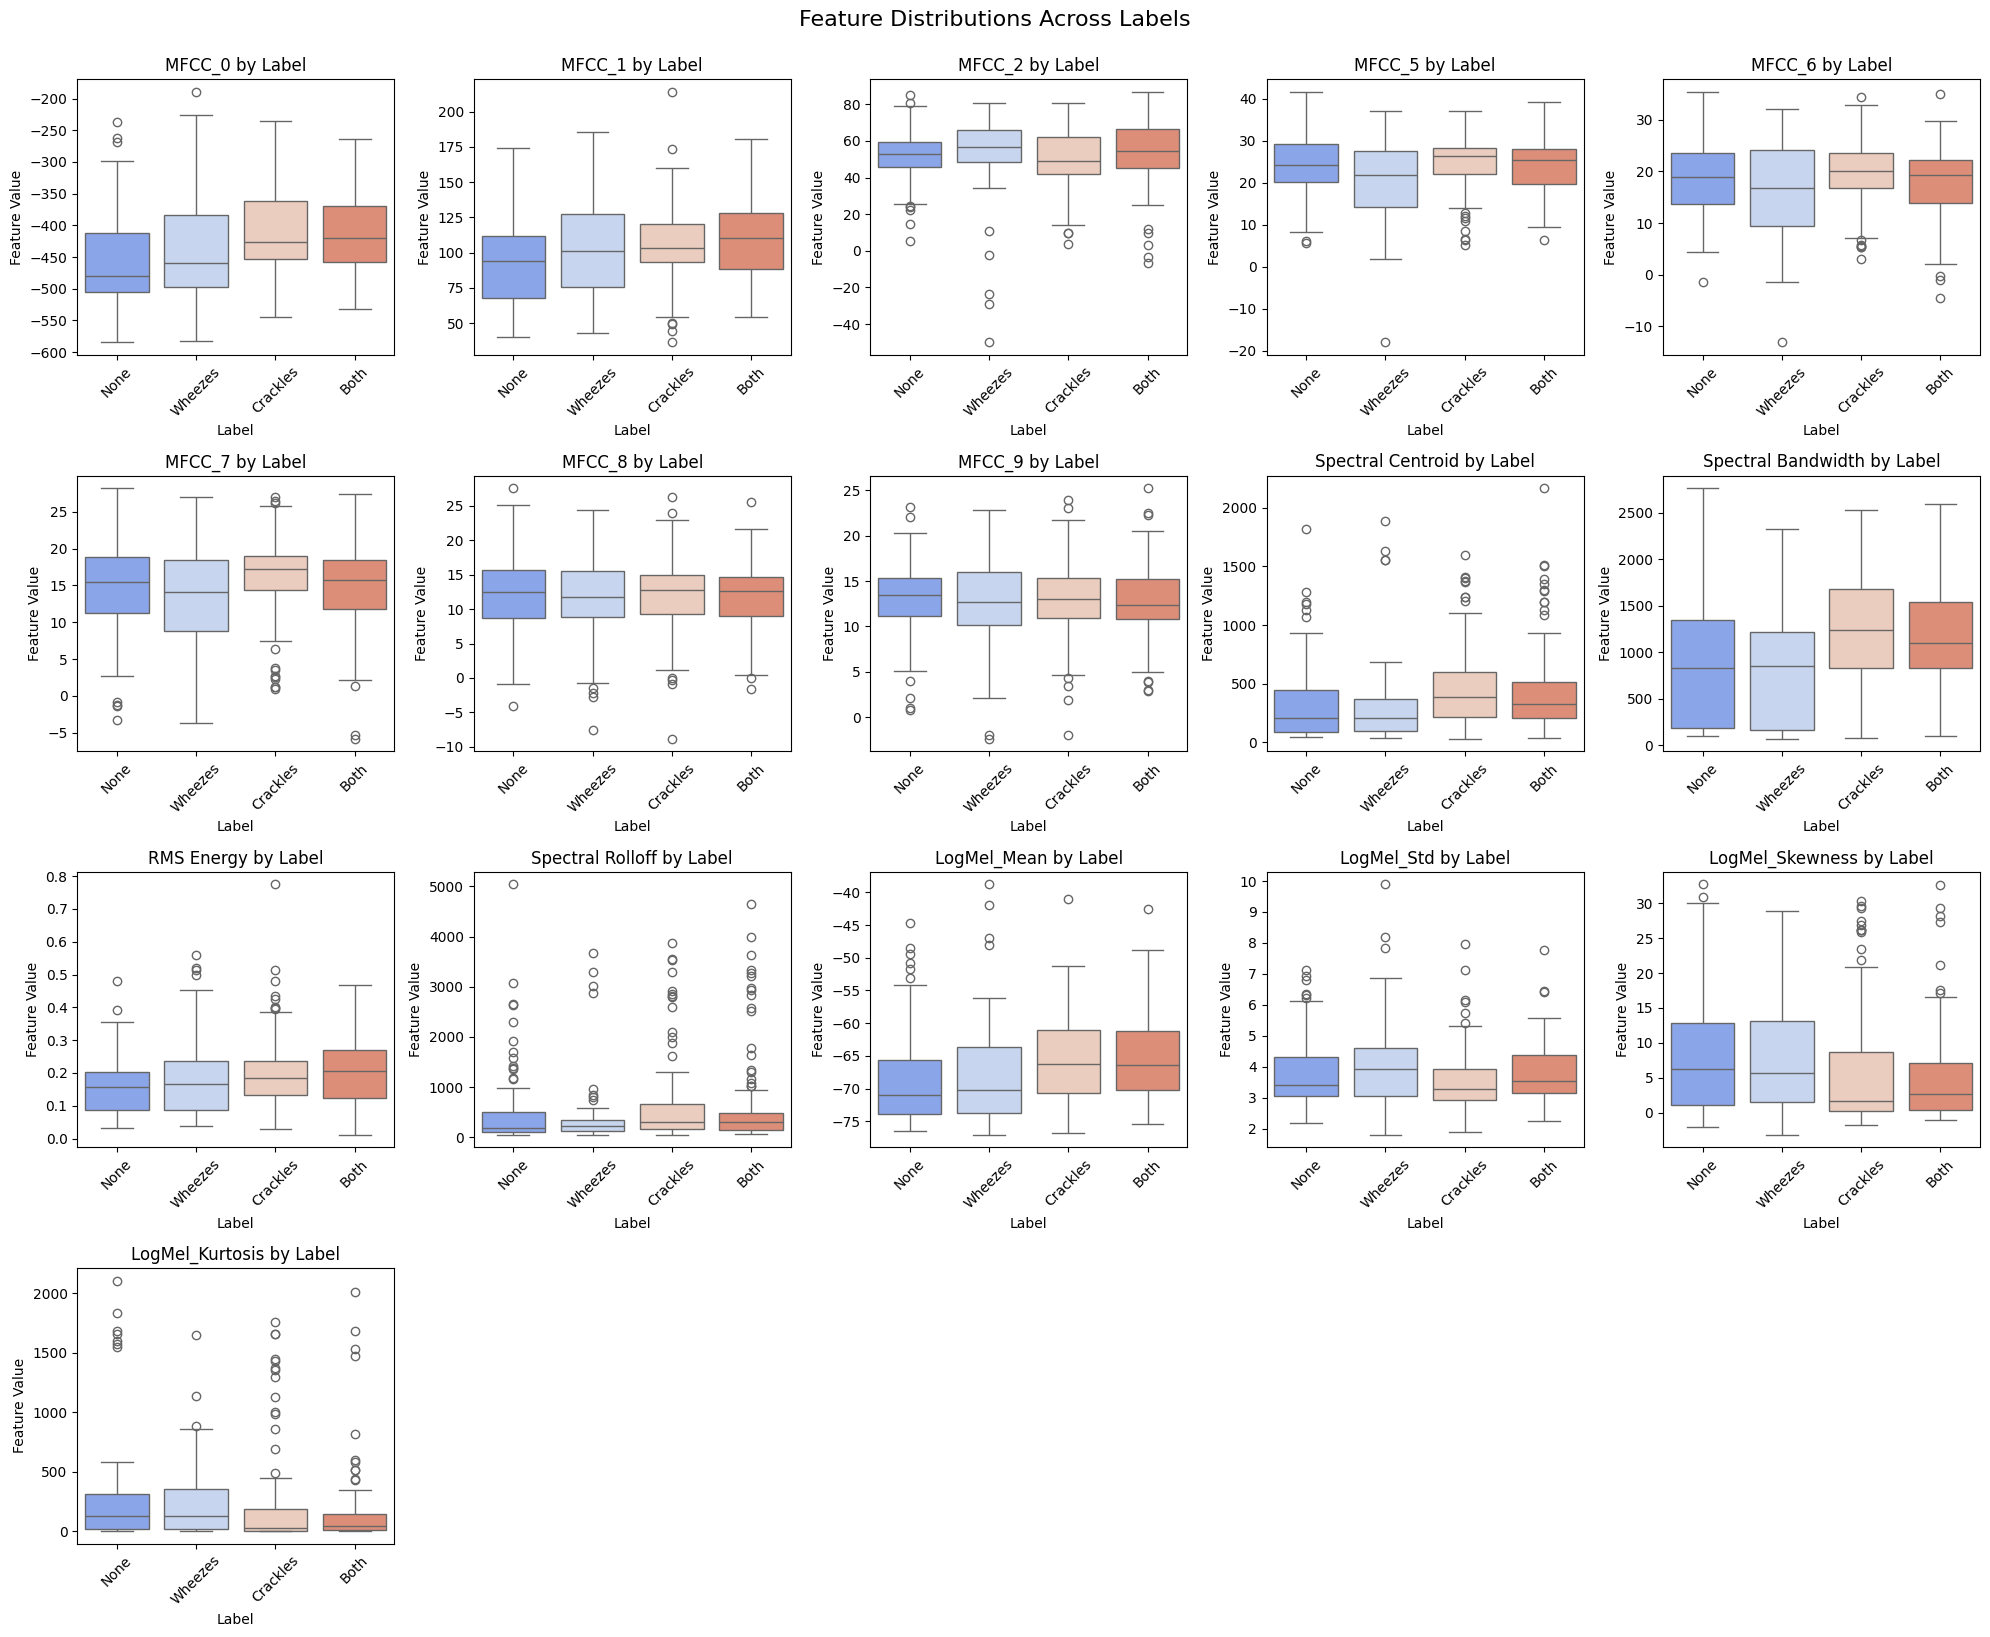

In [ ]:
import math

def plot_boxplots_by_label(feature_matrix, labels, cols=5):
    """Plot boxplots of each feature grouped by labels in a dynamically sized grid.

    Args:
        feature_matrix (pd.DataFrame): DataFrame containing features (samples × features).
        labels (list or array): Corresponding labels for each sample.
        cols (int, optional): Number of columns for subplot grid. Defaults to 5.

    Returns:
        None: Displays the boxplot figure.
    """
    num_features = feature_matrix.shape[1]
    rows = math.ceil(num_features / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

    for i, feature in enumerate(feature_matrix.columns):
        row, col = divmod(i, cols)
        ax = axes[row, col] if rows > 1 else axes[col]

        sns.boxplot(x=labels, y=feature_matrix[feature], ax=ax, palette="coolwarm")
        ax.set_title(f"{feature} by Label", fontsize=12)
        ax.set_xlabel("Label", fontsize=10)
        ax.set_ylabel("Feature Value", fontsize=10)
        ax.tick_params(axis="x", rotation=45)

    total_subplots = rows * cols
    if num_features < total_subplots:
        for j in range(num_features, total_subplots):
            fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.suptitle("Feature Distributions Across Labels", fontsize=16, y=1.02)
    plt.show()

# Execute the function
plot_boxplots_by_label(filtered_feature_matrix_V, labels)

## Domain discovery

Check if any of the metadata (Recording Device, Age, Sex, BMI) reveal any hidden domain.

In [ ]:
METADATA_FILE = "/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/demographic_info.txt"

def load_metadata(metadata_file: str) -> pd.DataFrame:
    """Loads demographic metadata from the metadata file.

    Args:
        metadata_file (str): Path to demographic metadata file.

    Returns:
        pd.DataFrame: DataFrame with demographic information.
    """
    df_metadata = pd.read_csv(metadata_file, sep='\s+', header=None,
                              names=["Patient ID", "Age", "Sex", "BMI", "Weight", "Height"])
    df_metadata = df_metadata[["Patient ID", "Age", "Sex", "BMI"]]
    return df_metadata

def categorize_intervals(df: pd.DataFrame) -> pd.DataFrame:
    """Categorizes Age and BMI into interval groups.

    Args:
        df (pd.DataFrame): Demographic metadata DataFrame.

    Returns:
        pd.DataFrame: DataFrame with categorized age and BMI.
    """
    # Age categorization
    age_bins = [0, 12, 19, 35, 60, 120]
    age_labels = ["<12", "12 - 20", "20 - 35", "35 - 60", ">60"]
    df["Age Group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, include_lowest=True)

    # BMI categorization
    bmi_bins = [0, 18.5, 25, 30, 100]
    bmi_labels = ["<18.5", "18.5 - 25", "25 - 30", ">30"]
    df["BMI Group"] = pd.cut(df["BMI"], bins=bmi_bins, labels=bmi_labels, include_lowest=True)

    return df

def extract_recording_device(filename: str) -> str:
    """Extracts recording device identifier from audio filename.

    Args:
        filename (str): Audio filename.

    Returns:
        str: Recording device identifier.
    """
    return filename.split("_")[4].split(".")[0]

def generate_labels_from_metadata(audio_folder: str, df_metadata: pd.DataFrame) -> pd.DataFrame:
    """Generates DataFrame with Filename and interval-based labels (Age, Sex, BMI, Device).

    Args:
        audio_folder (str): Path to folder containing audio files.
        df_metadata (pd.DataFrame): DataFrame with categorized demographic info.

    Returns:
        pd.DataFrame: DataFrame of filenames with corresponding metadata labels.
    """
    audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]
    labels_data = []

    for file in audio_files:
        patient_id = int(file.split("_")[0])
        recording_device = extract_recording_device(file)

        patient_info = df_metadata[df_metadata["Patient ID"] == patient_id]

        if patient_info.empty:
            continue

        patient_record = {
            "Filename": file,
            "Age Group": patient_info["Age Group"].values[0],
            "Sex": patient_info["Sex"].values[0],
            "BMI Group": patient_info["BMI Group"].values[0],
            "Recording Device": recording_device
        }

        labels_data.append(patient_record)

    return pd.DataFrame(labels_data)

# Generate labels dataframe.
metadata = load_metadata(METADATA_FILE)
metadata = categorize_intervals(metadata)
labels = generate_labels_from_metadata(AUDIO_FOLDER, metadata)

labels.drop(columns=["Filename"], inplace=True)

In [ ]:
labels

Age Group Sex BMI Group Recording Device
0         >60   M       >30         LittC2SE
1         >60   M   25 - 30         AKGC417L
2         >60   M   25 - 30         AKGC417L
3         >60   M   25 - 30         AKGC417L
4         >60   M   25 - 30         AKGC417L
..        ...  ..       ...              ...
447       >60   M   25 - 30         AKGC417L
448       >60   M   25 - 30         AKGC417L
449       >60   M   25 - 30         AKGC417L
450       >60   M   25 - 30         AKGC417L
451       >60   M   25 - 30         AKGC417L

[452 rows x 4 columns]


Visualizing PCA and t-SNE for label: Age Group



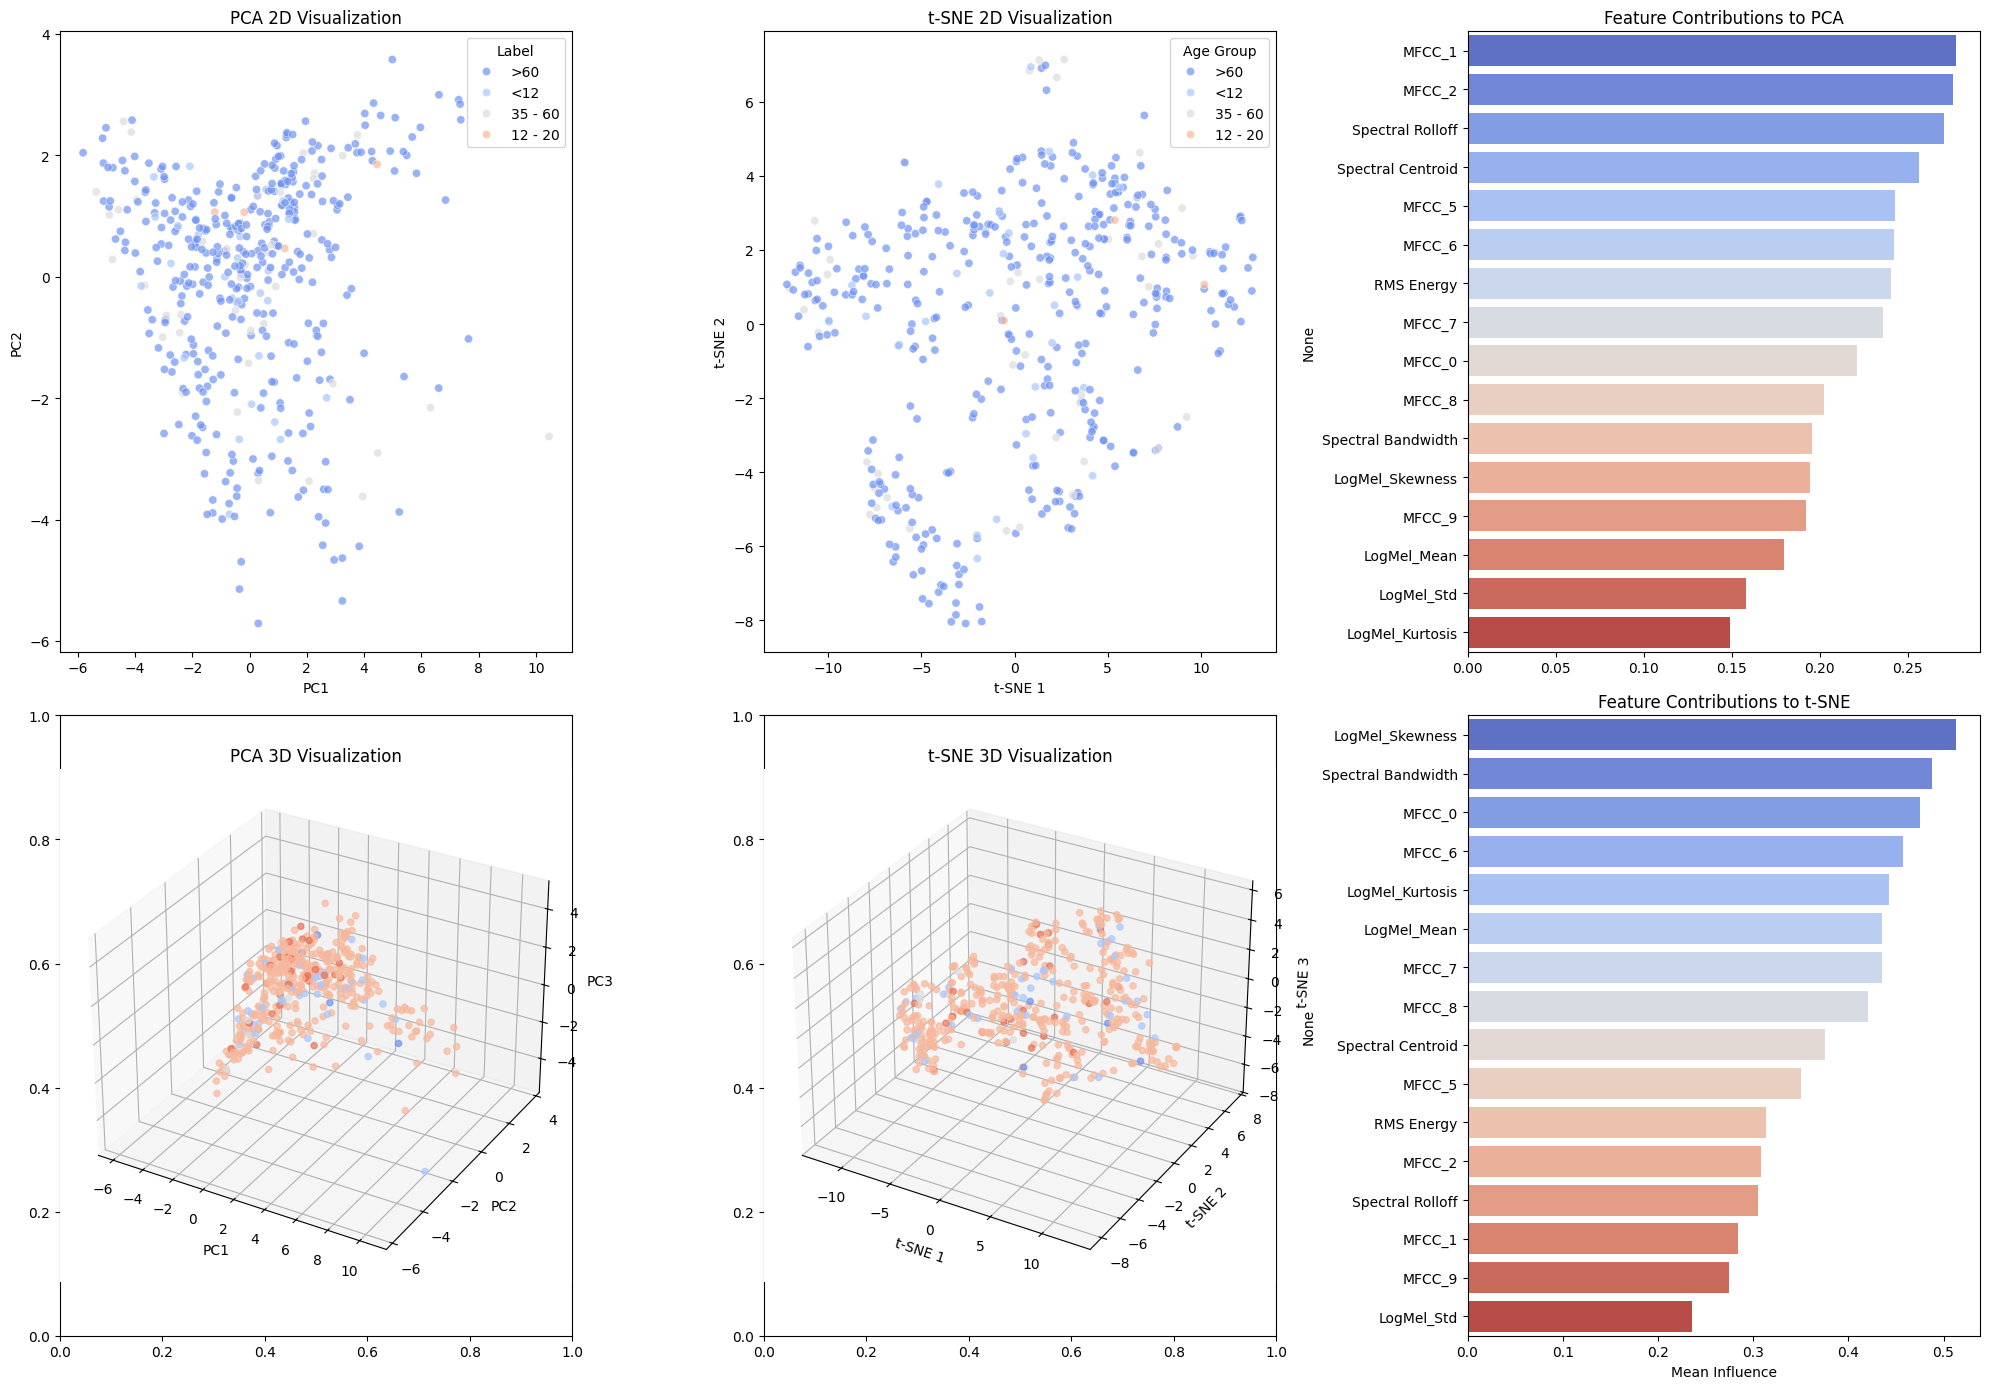


Visualizing PCA and t-SNE for label: Sex



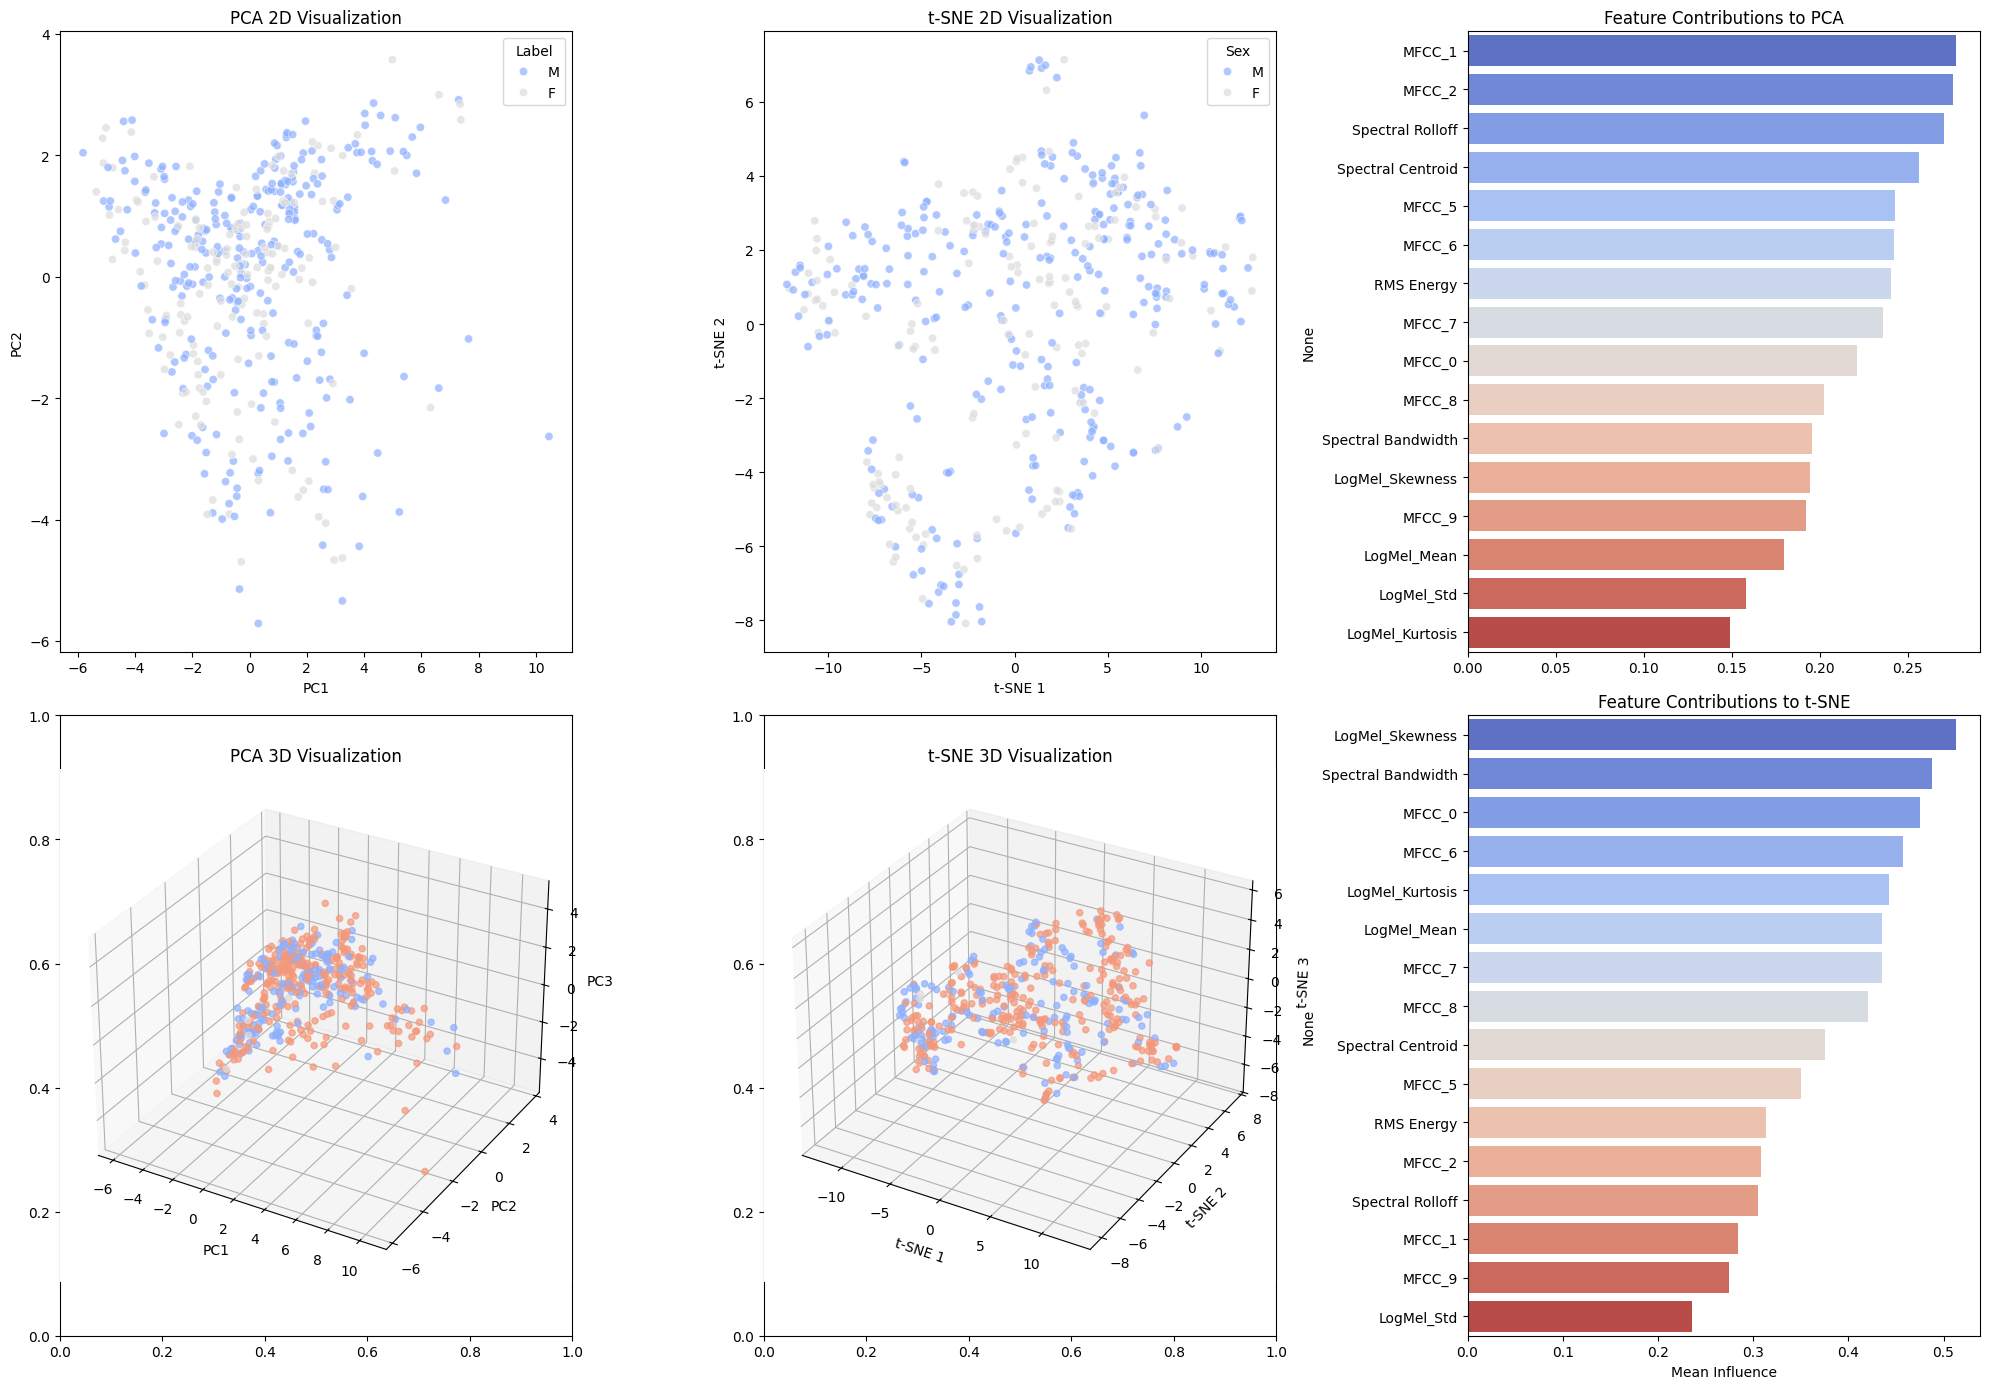


Visualizing PCA and t-SNE for label: BMI Group



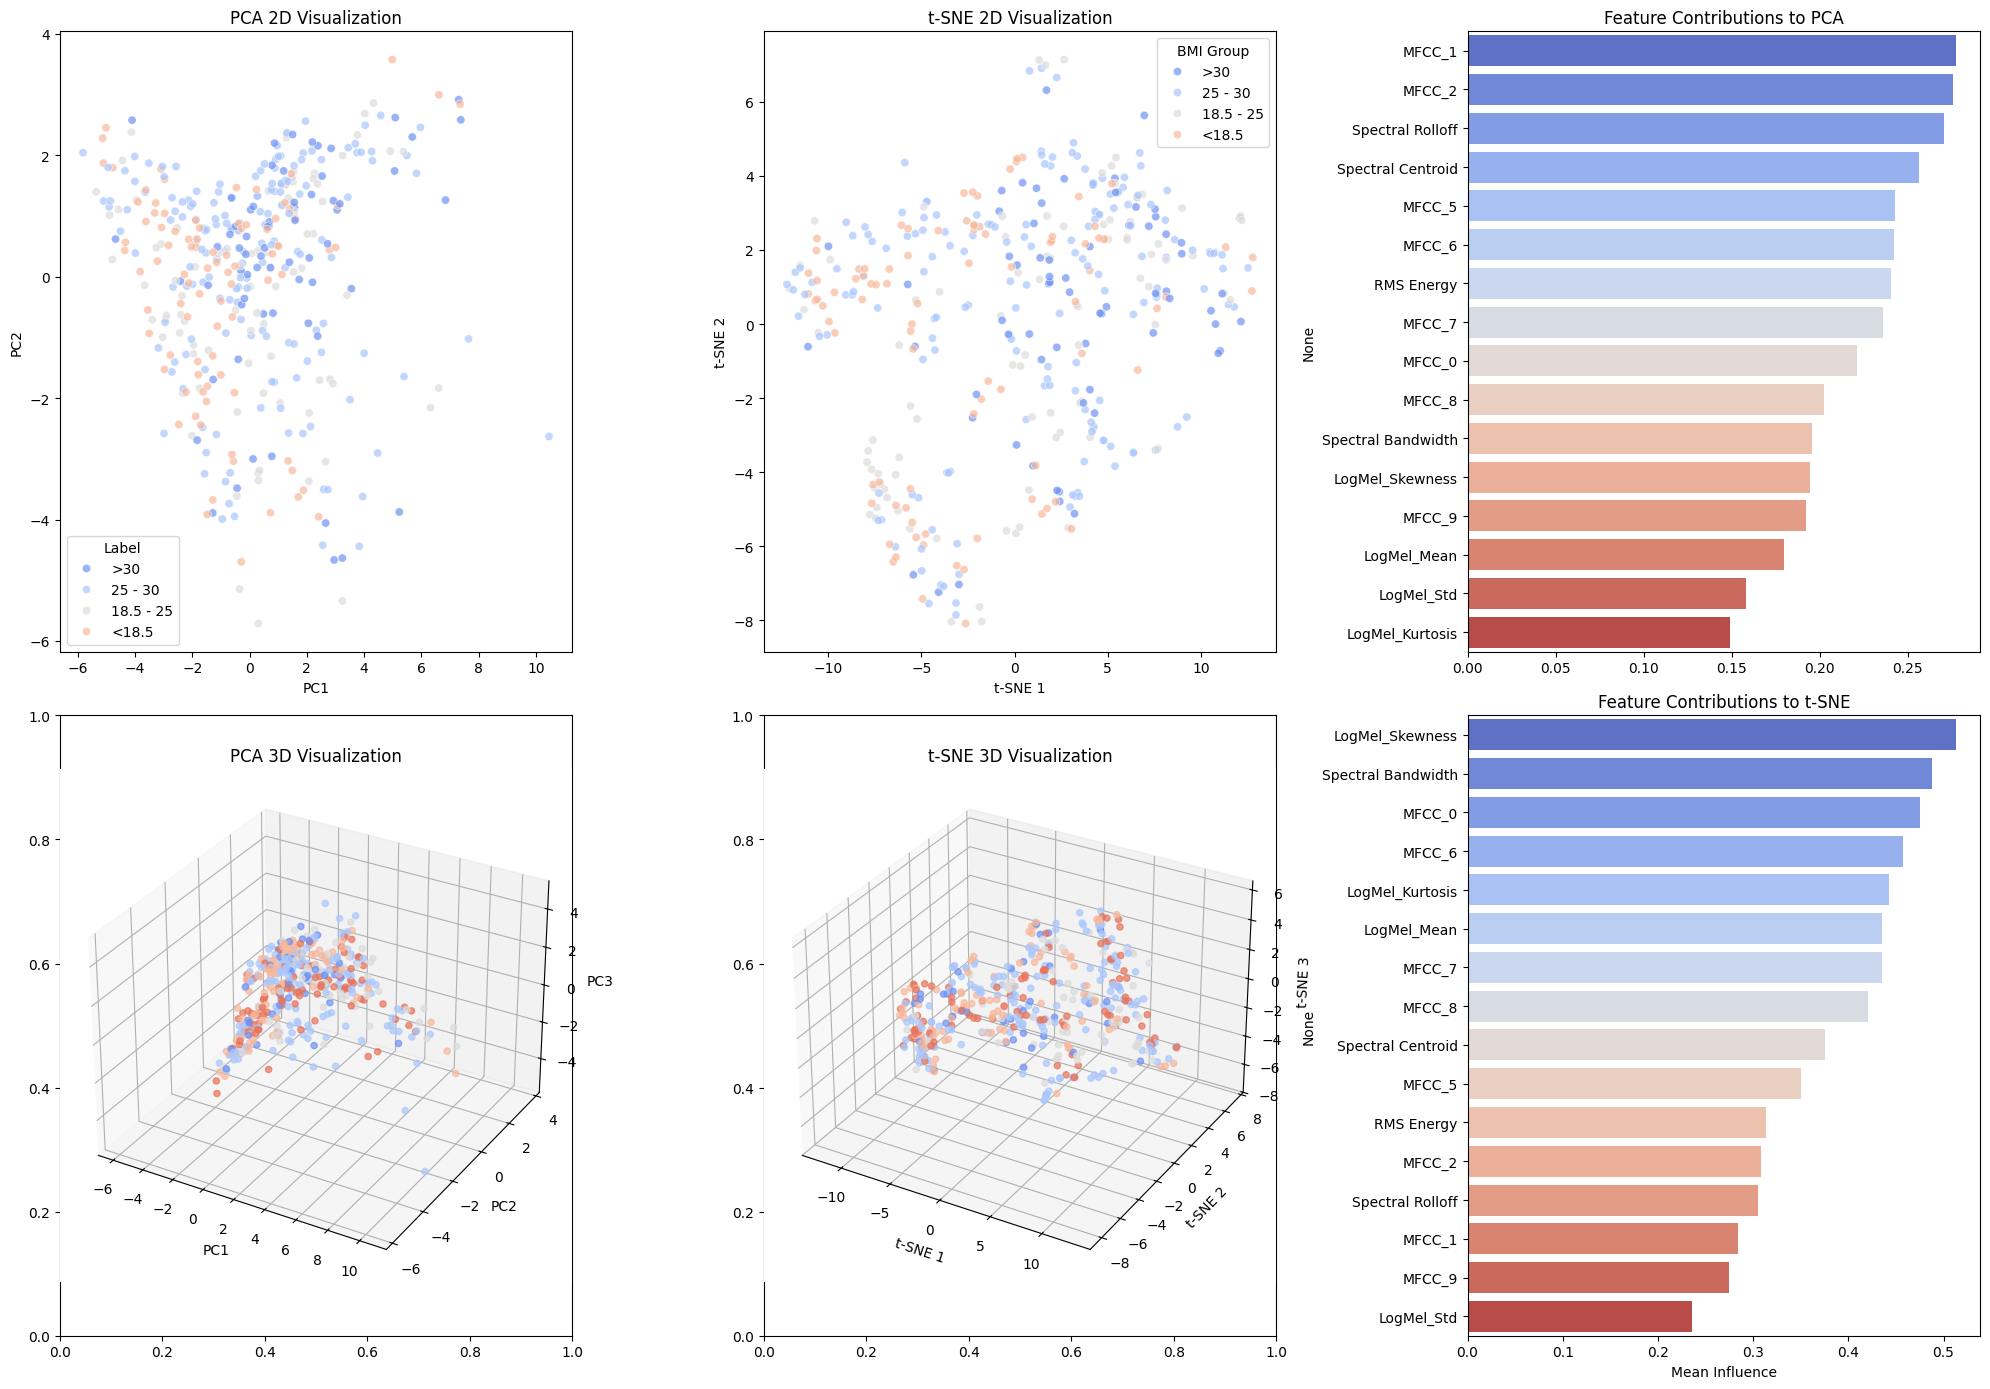


Visualizing PCA and t-SNE for label: Recording Device



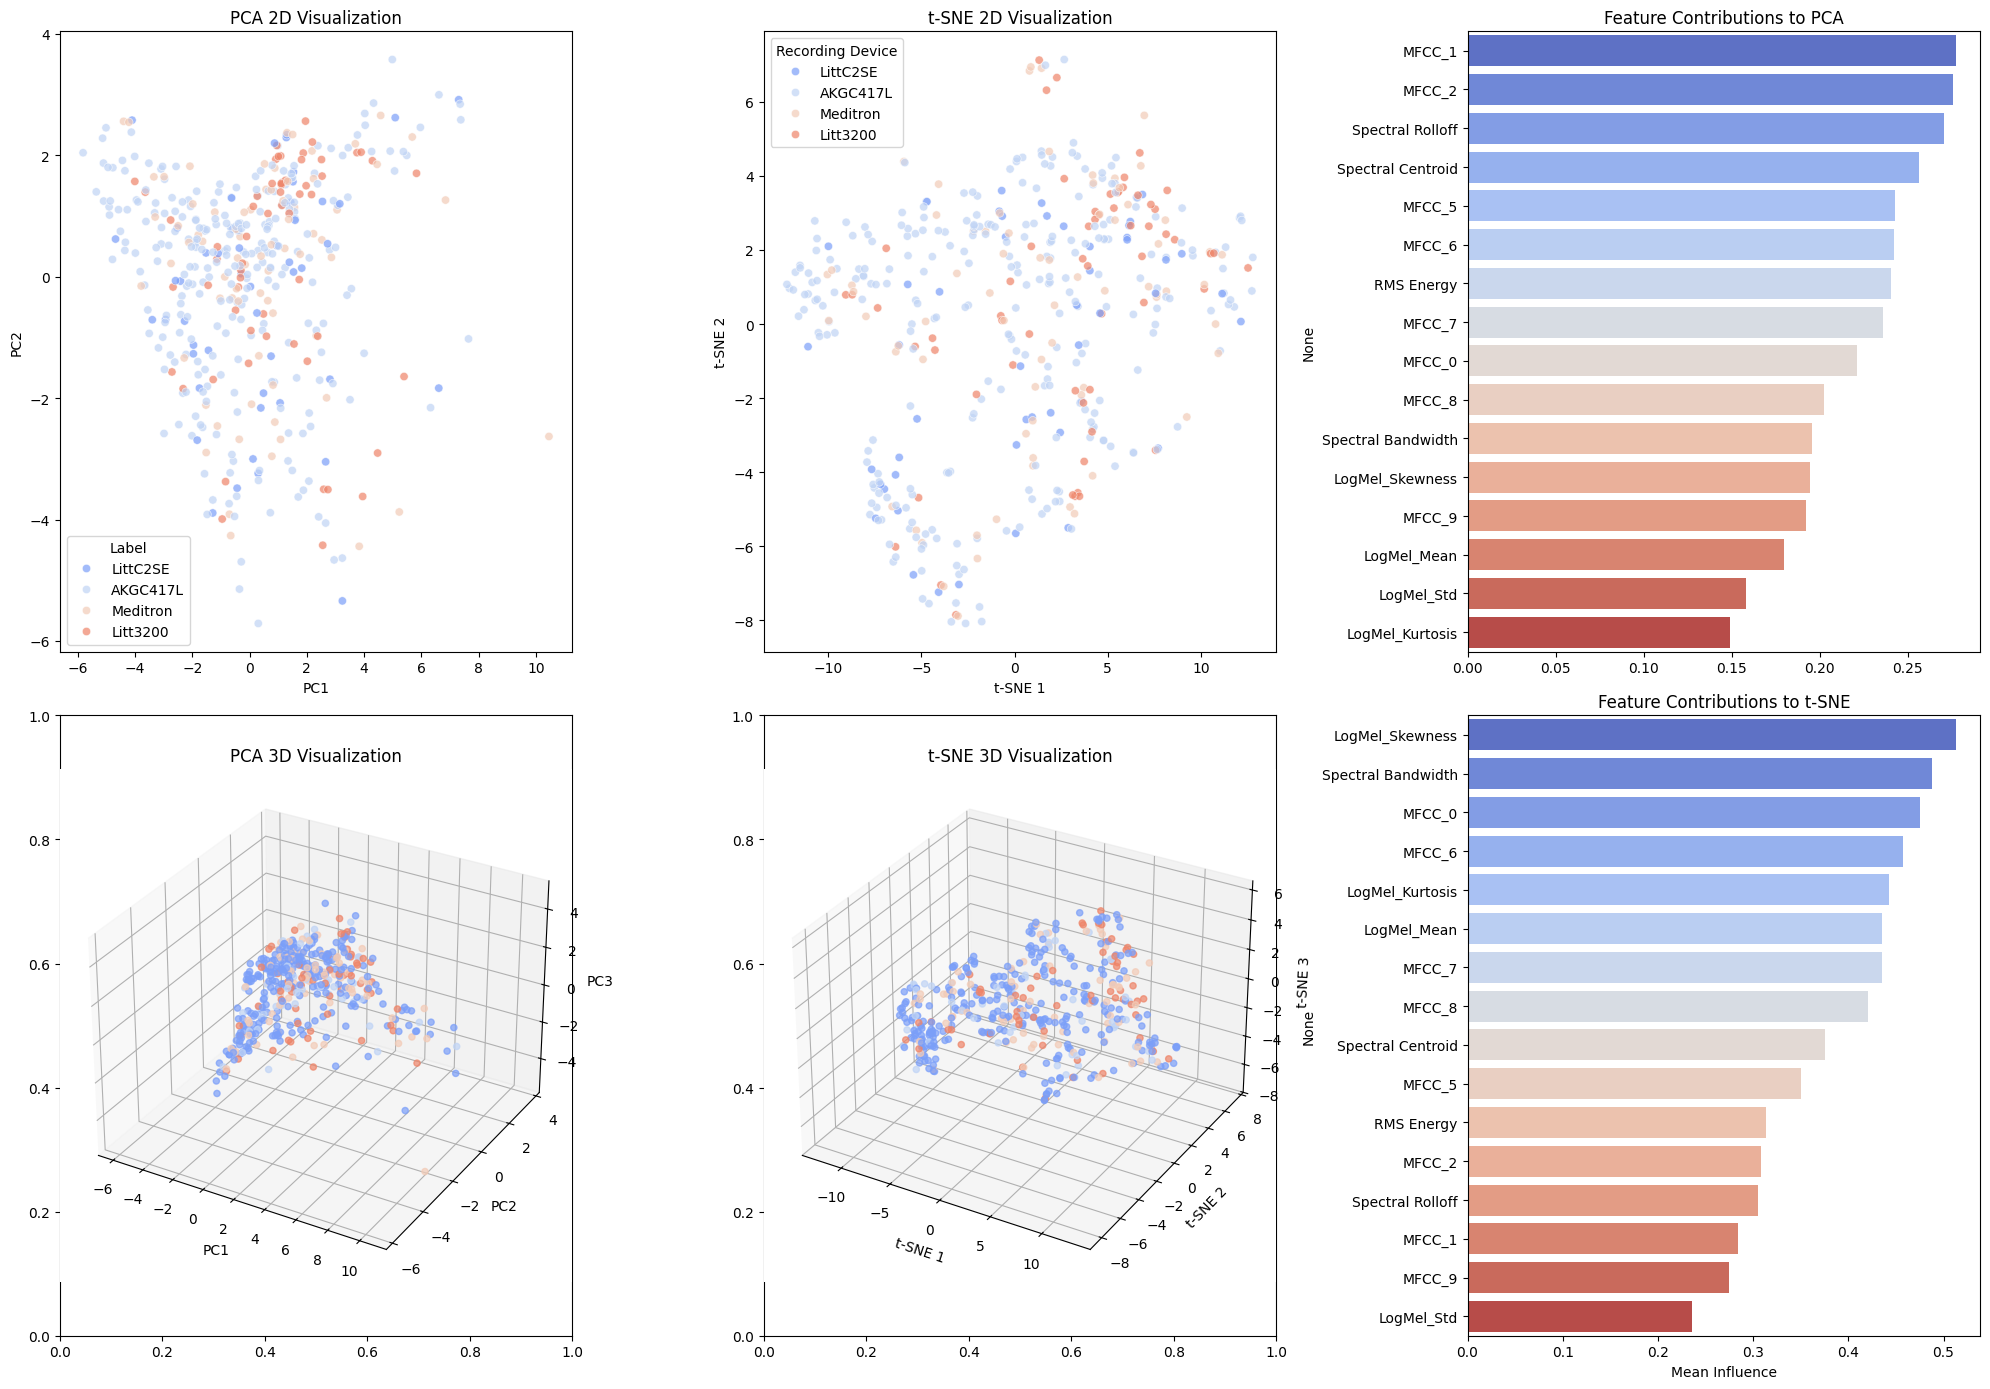

In [ ]:
for label in labels:
    print(f"\nVisualizing PCA and t-SNE for label: {label}\n")
    perform_pca_and_tsne(filtered_feature_matrix_V, labels[label])

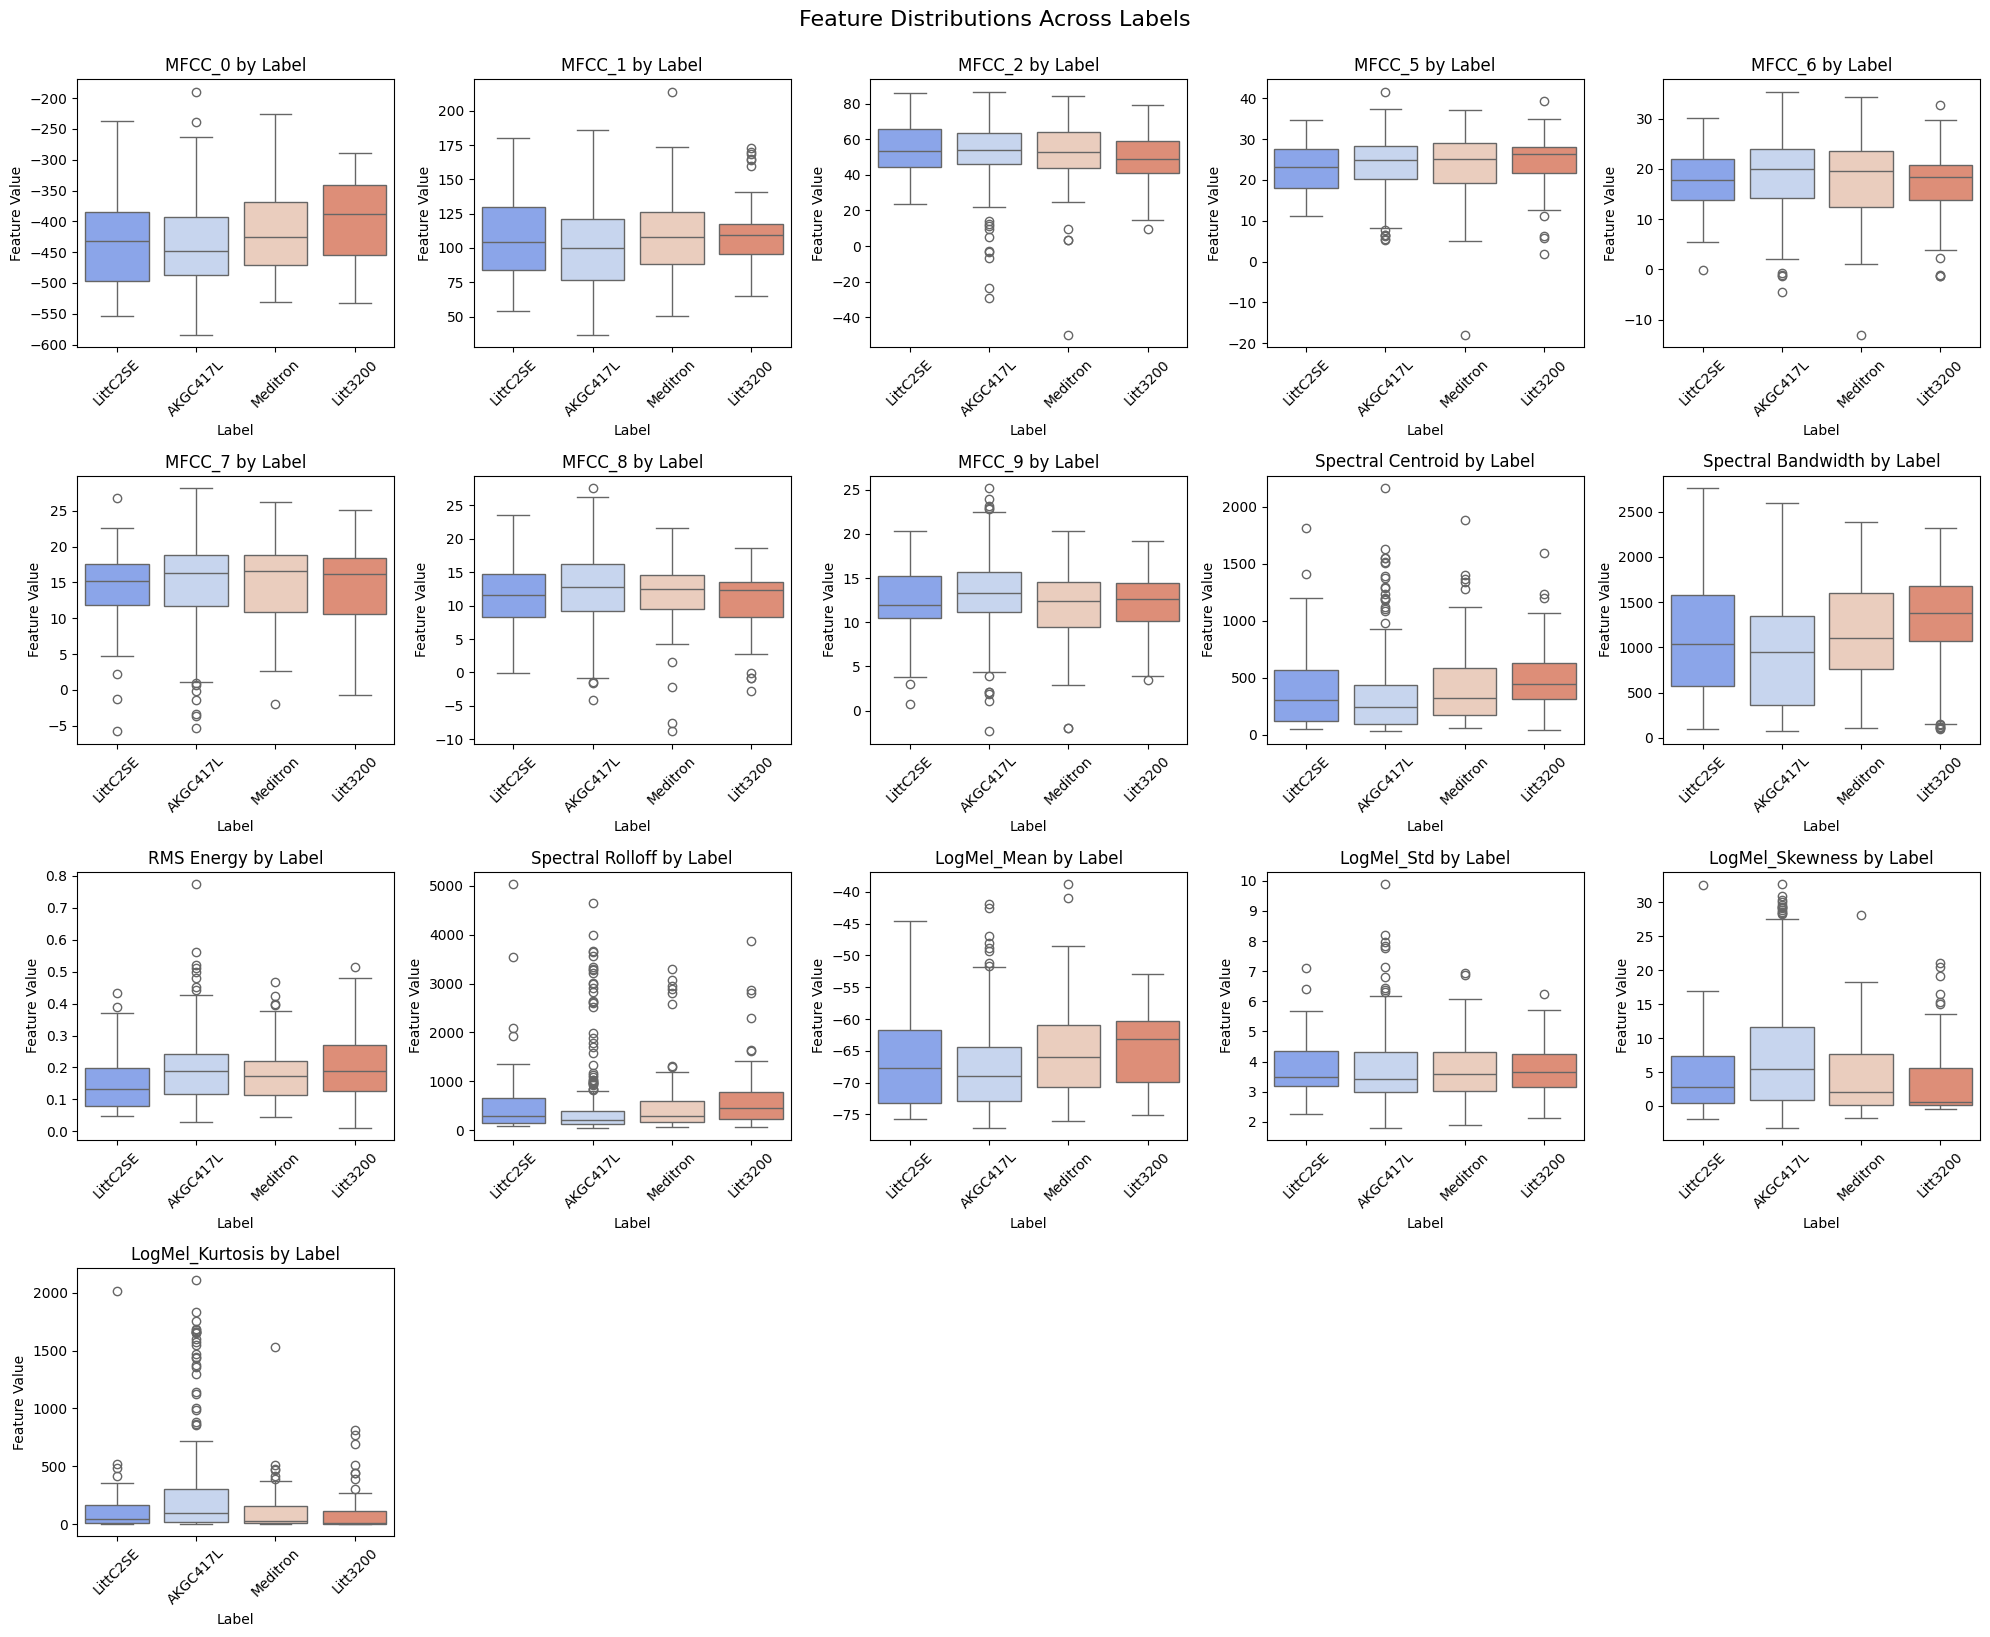

In [ ]:
plot_boxplots_by_label(filtered_feature_matrix_V, labels["Recording Device"])

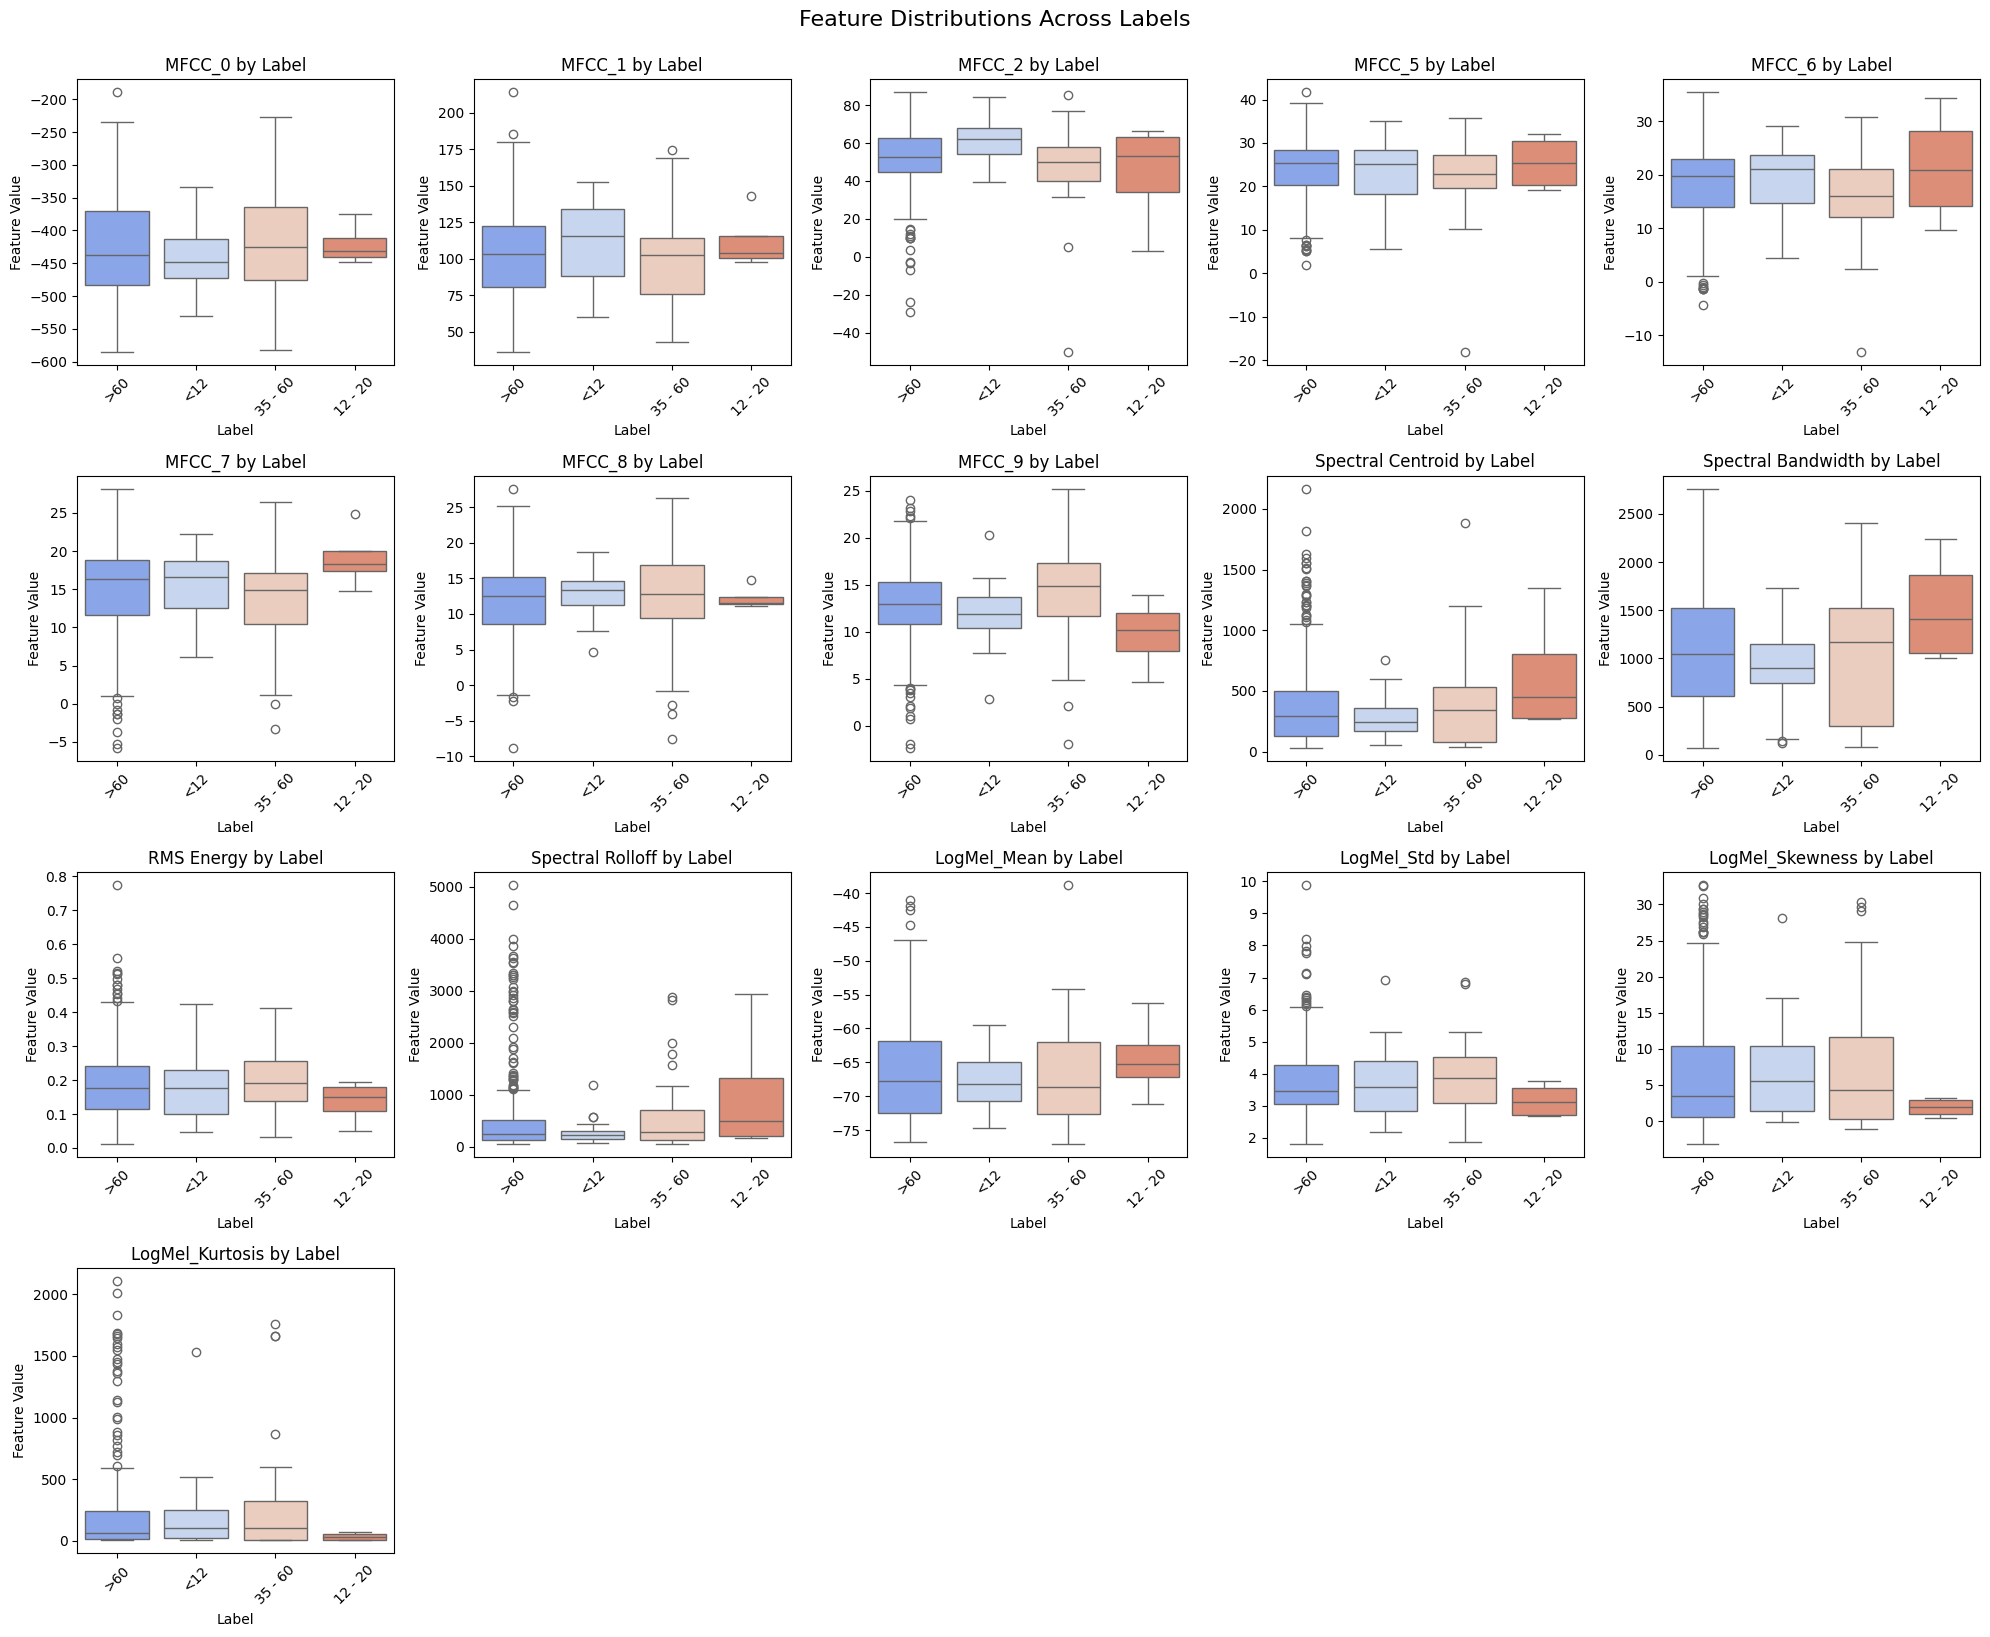

In [ ]:
plot_boxplots_by_label(filtered_feature_matrix_V, labels["Age Group"])

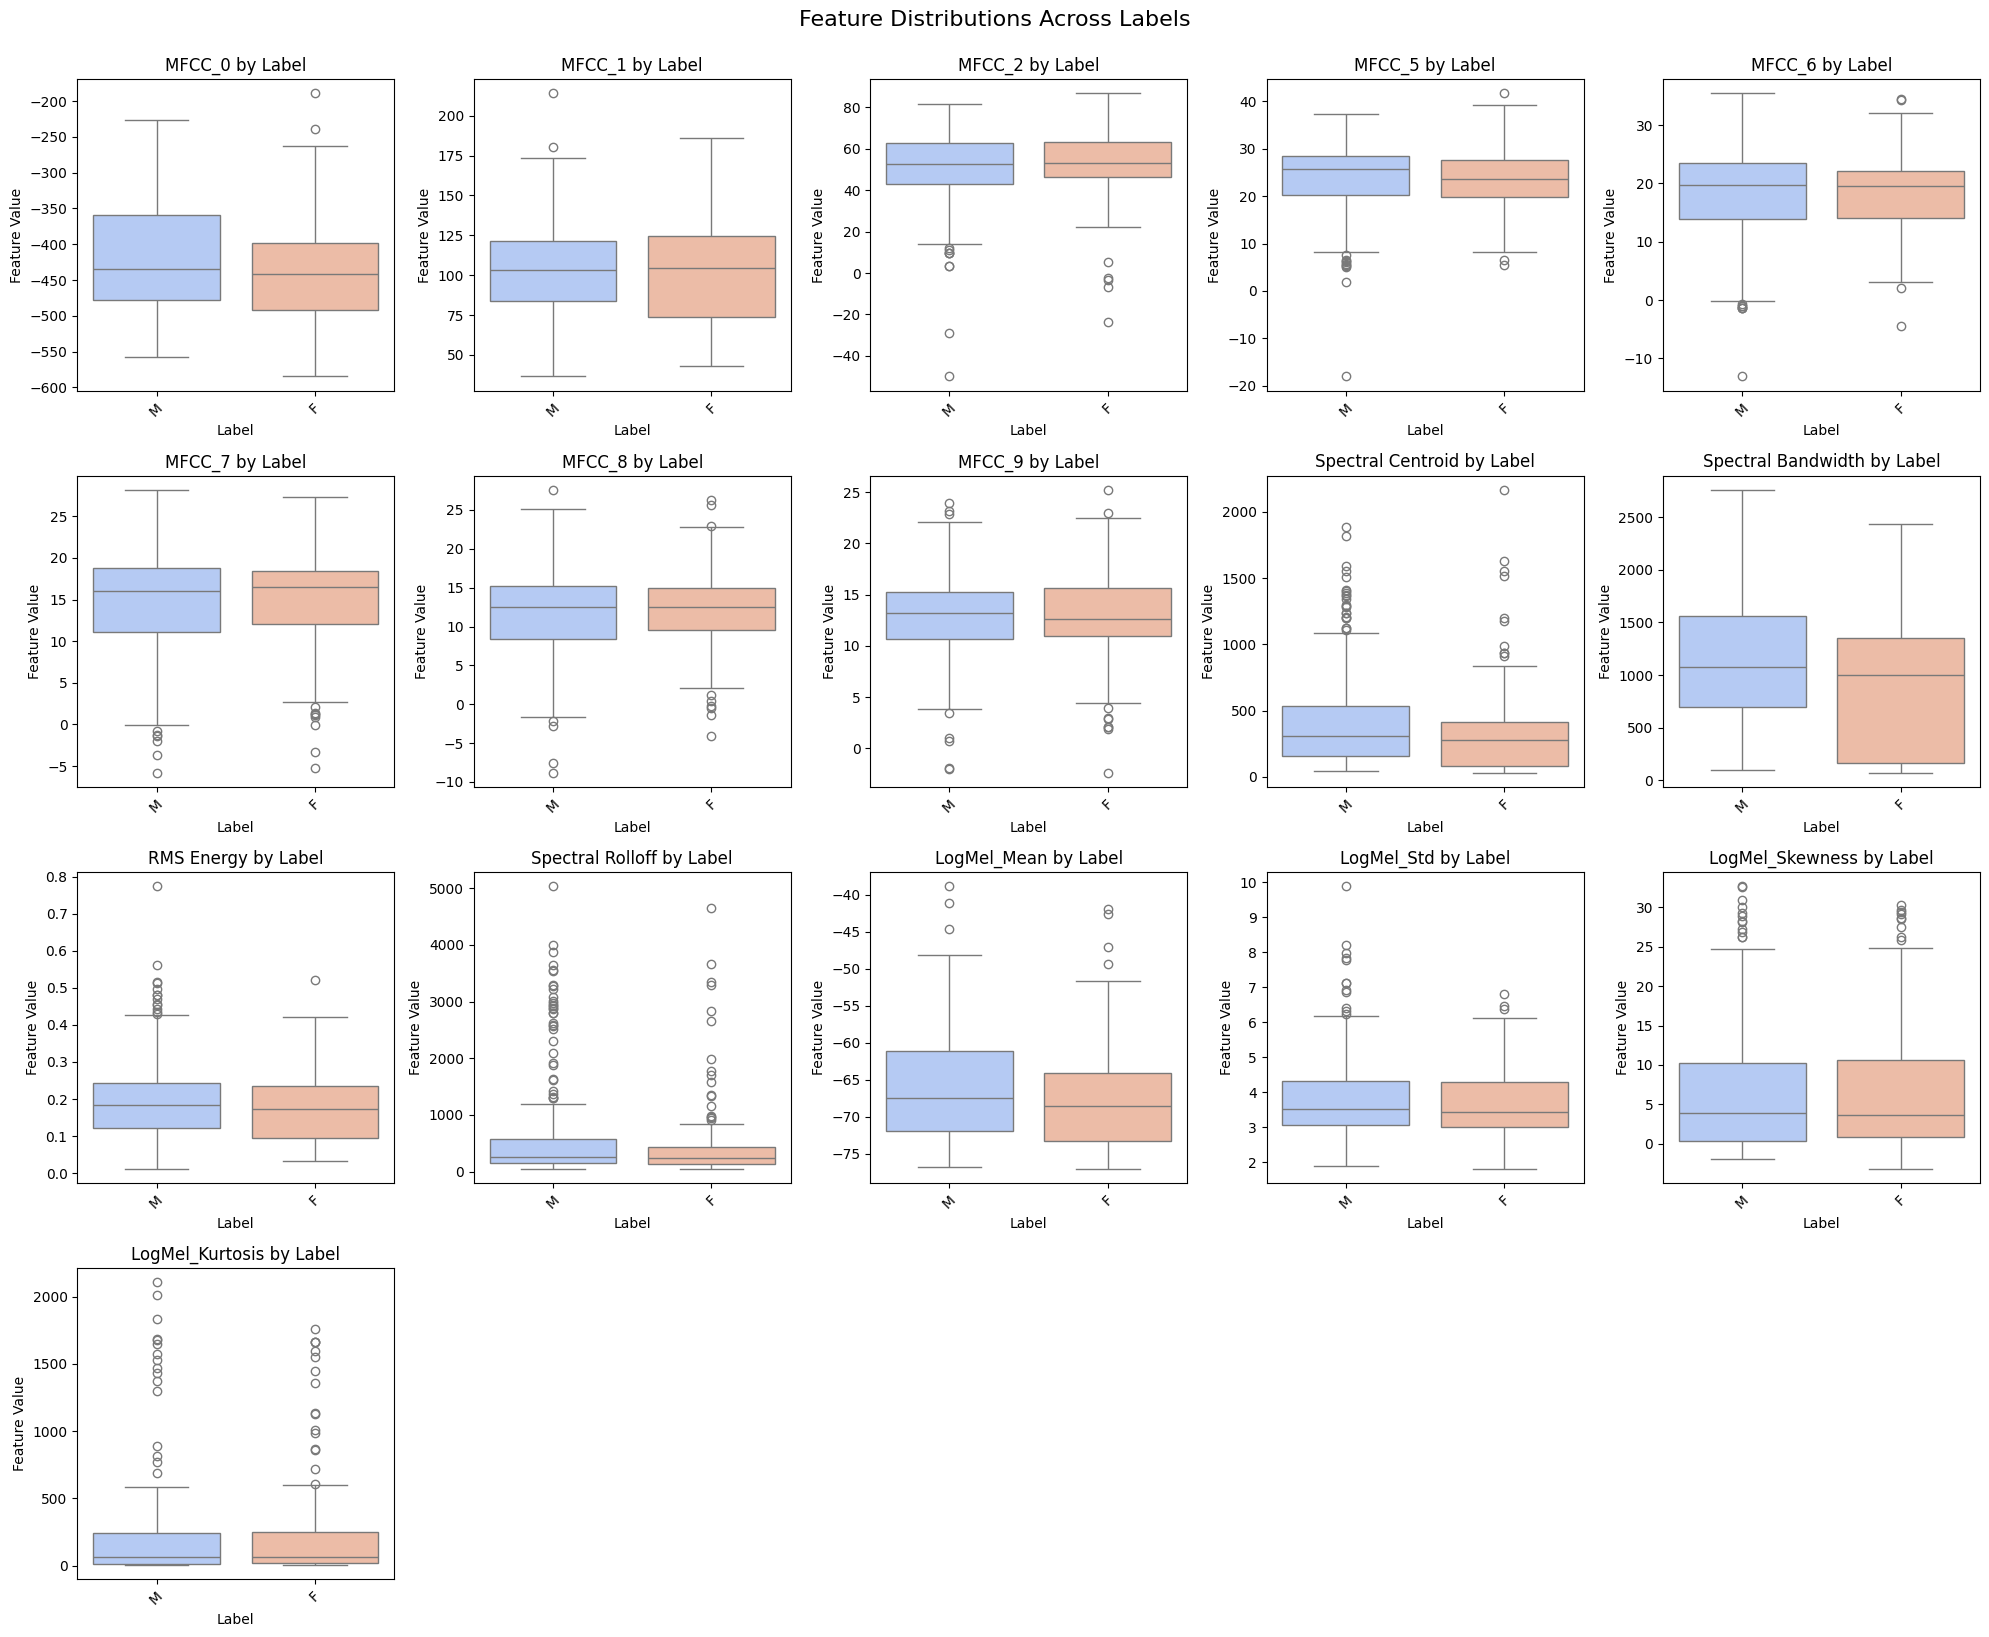

In [ ]:
plot_boxplots_by_label(filtered_feature_matrix_V, labels["Sex"])

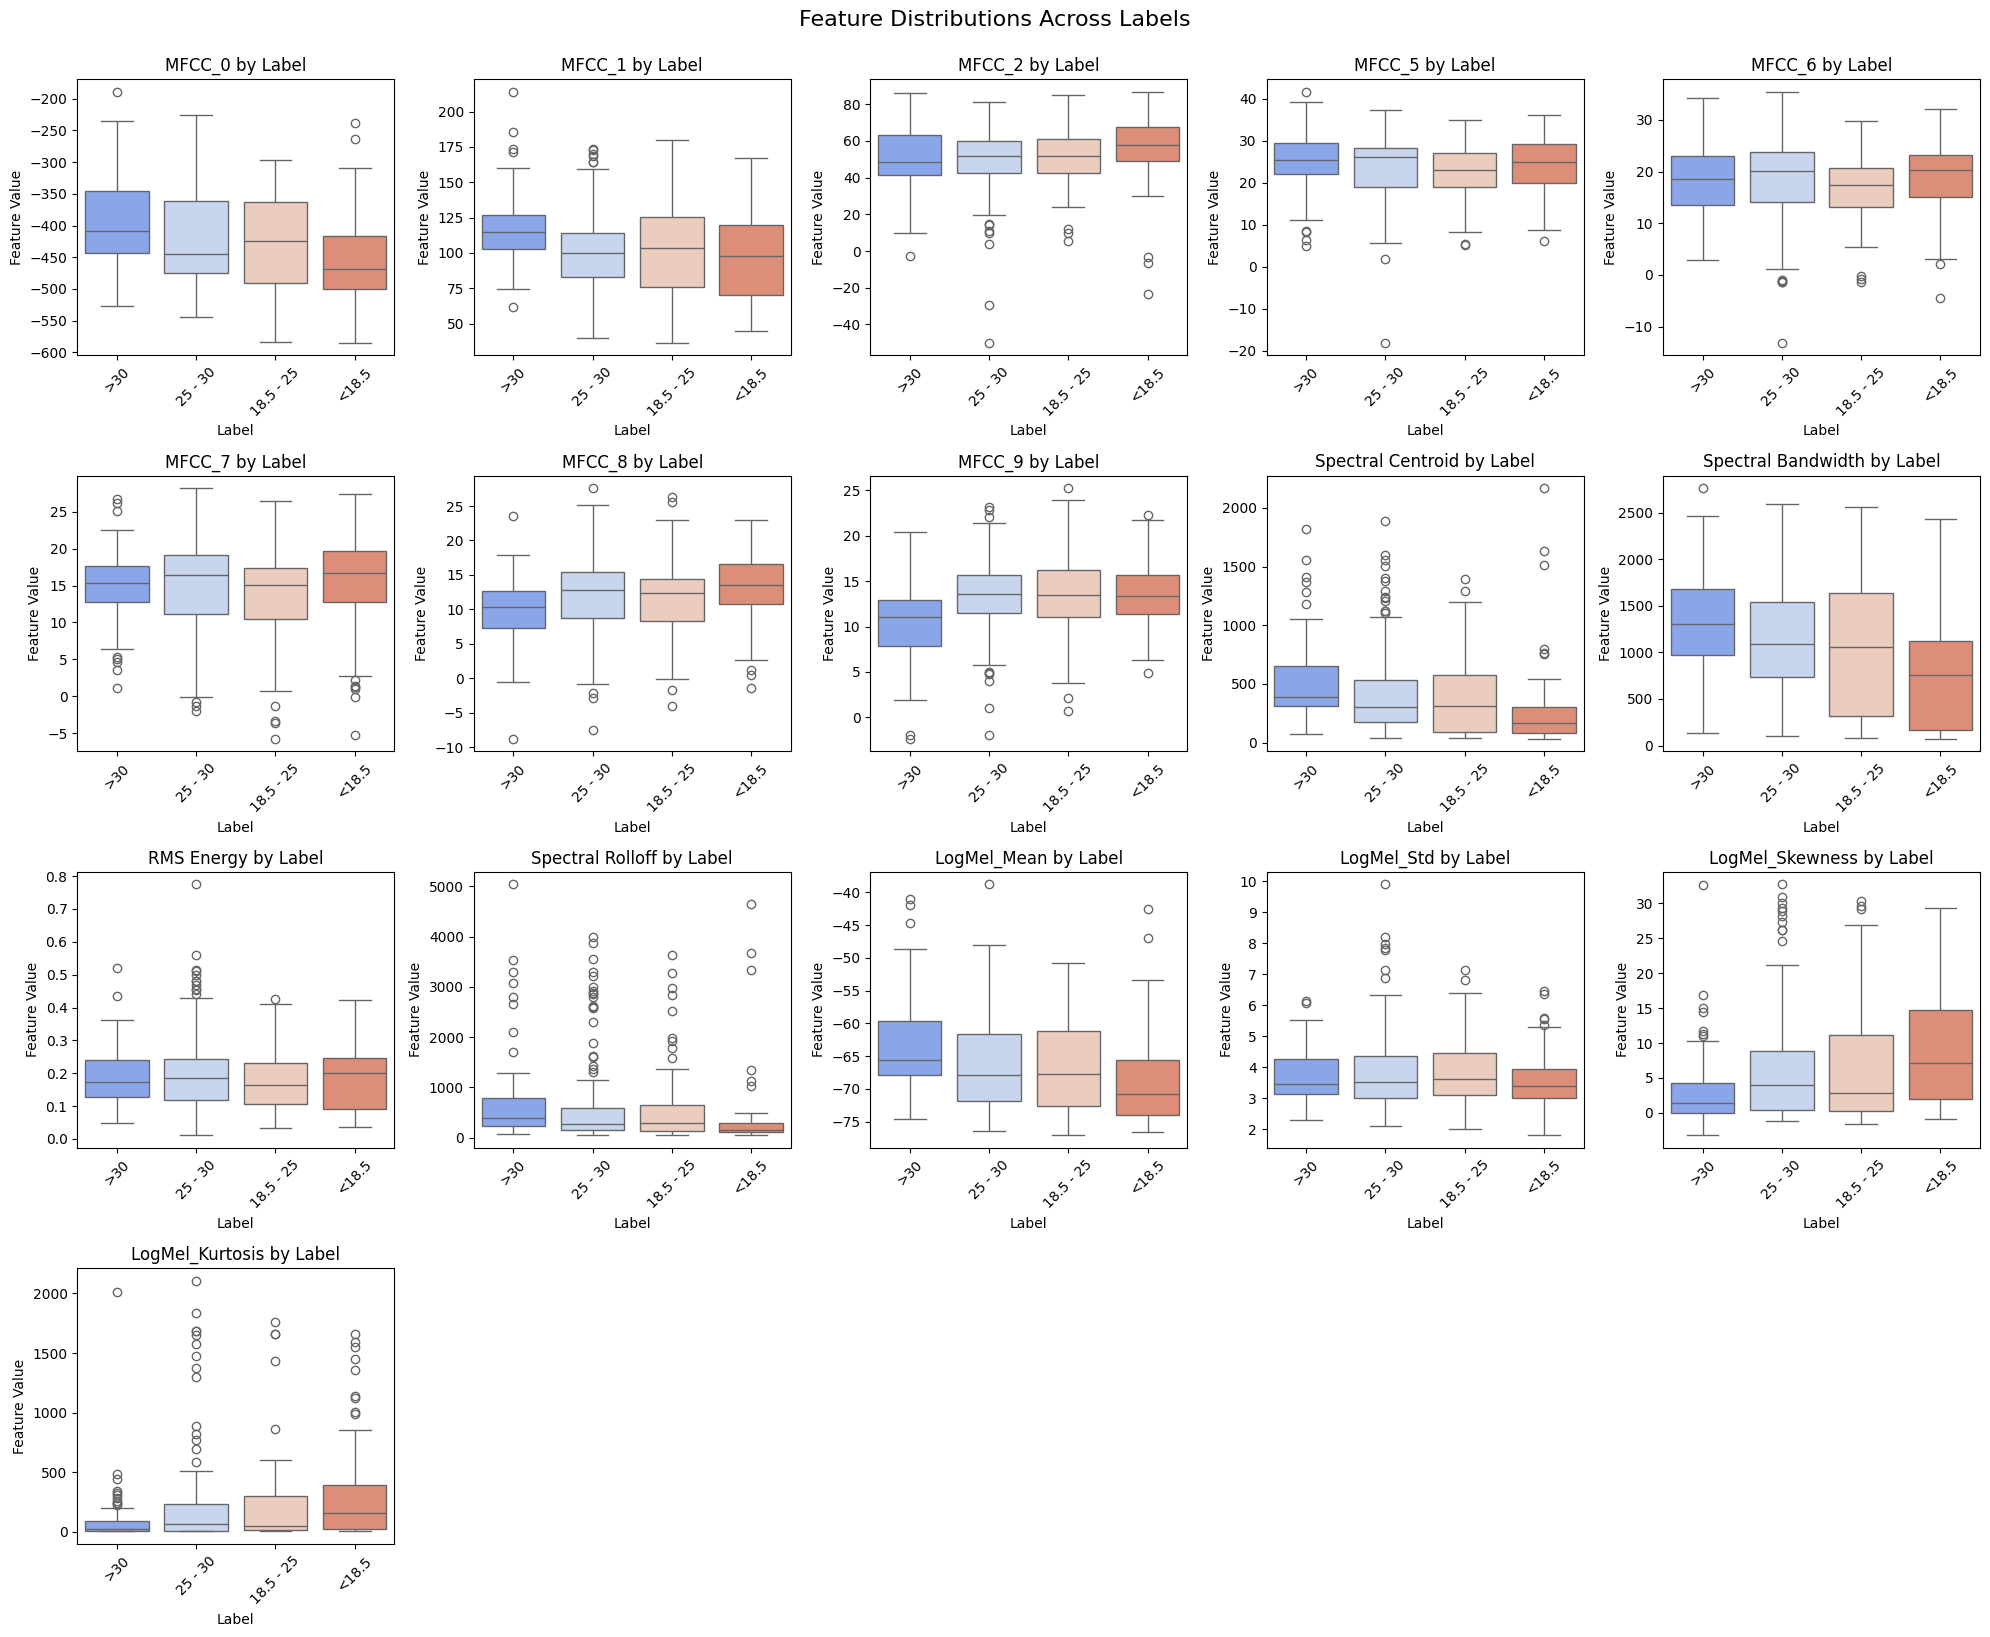

In [ ]:
plot_boxplots_by_label(filtered_feature_matrix_V, labels["BMI Group"])

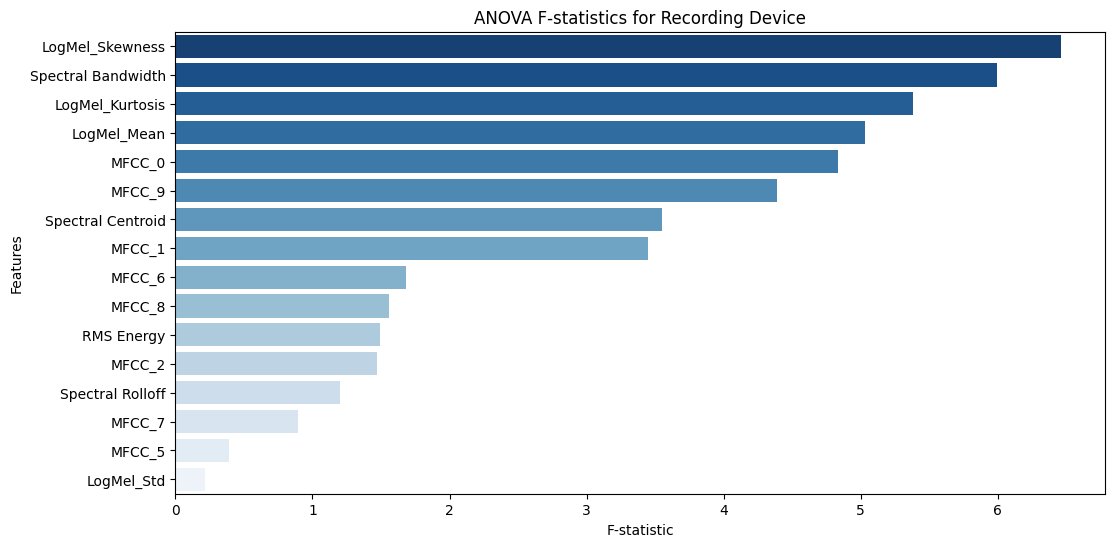

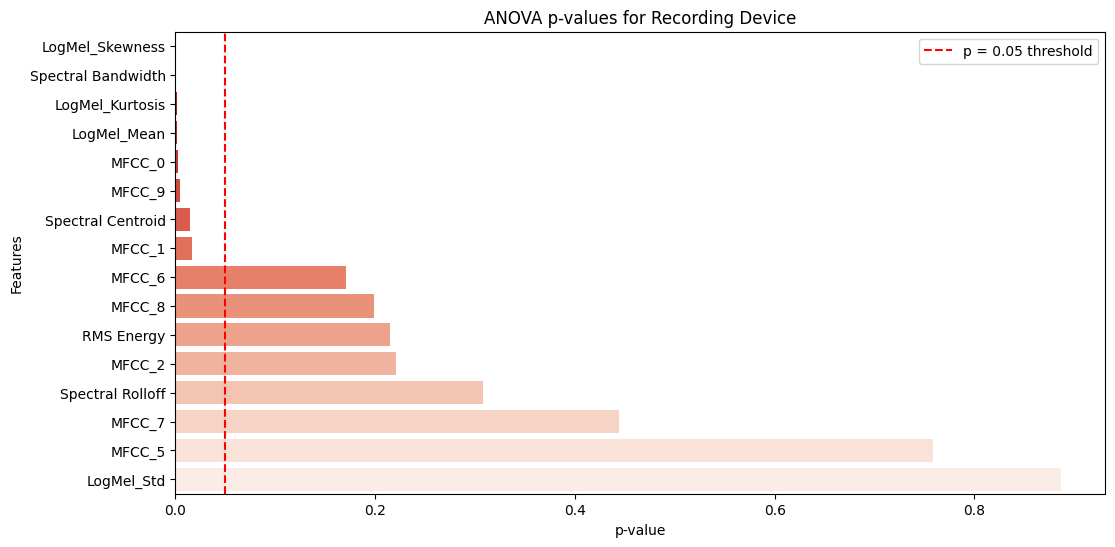

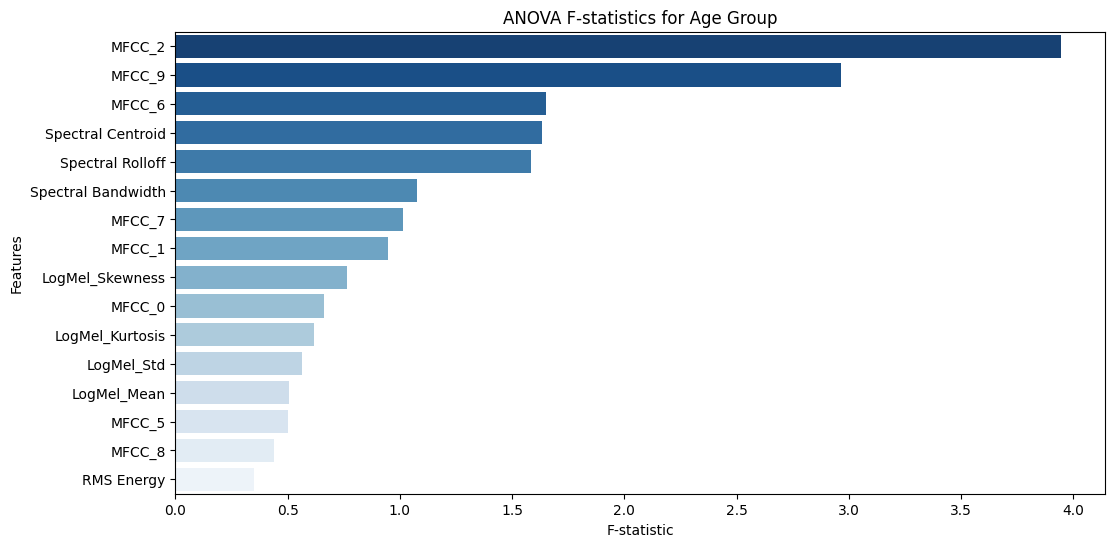

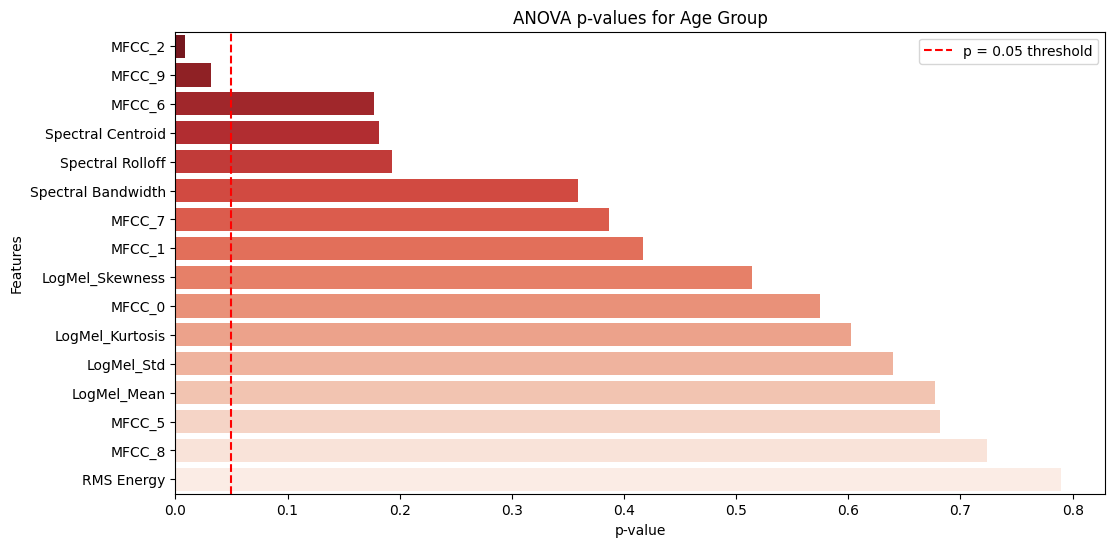

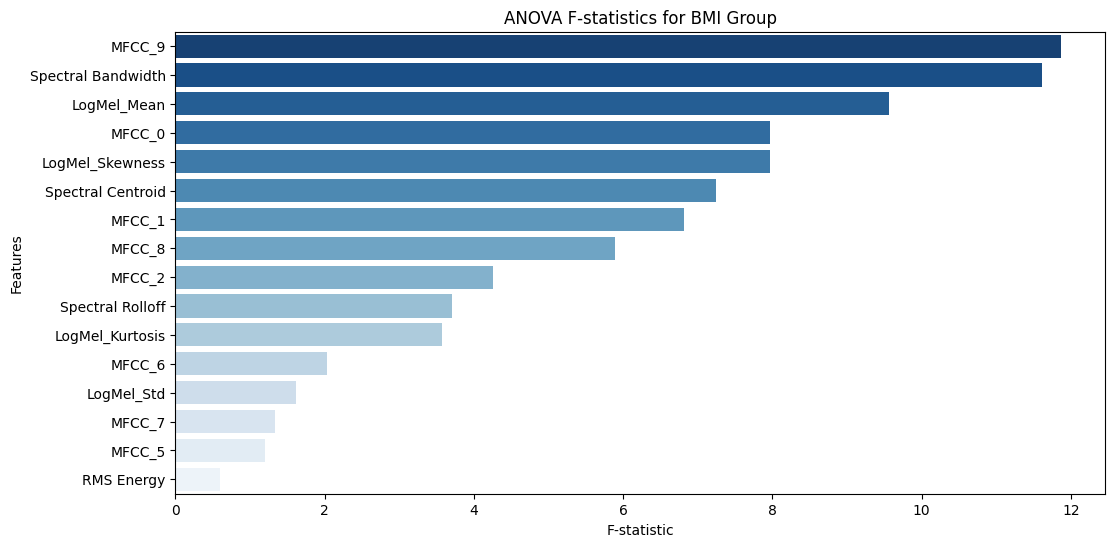

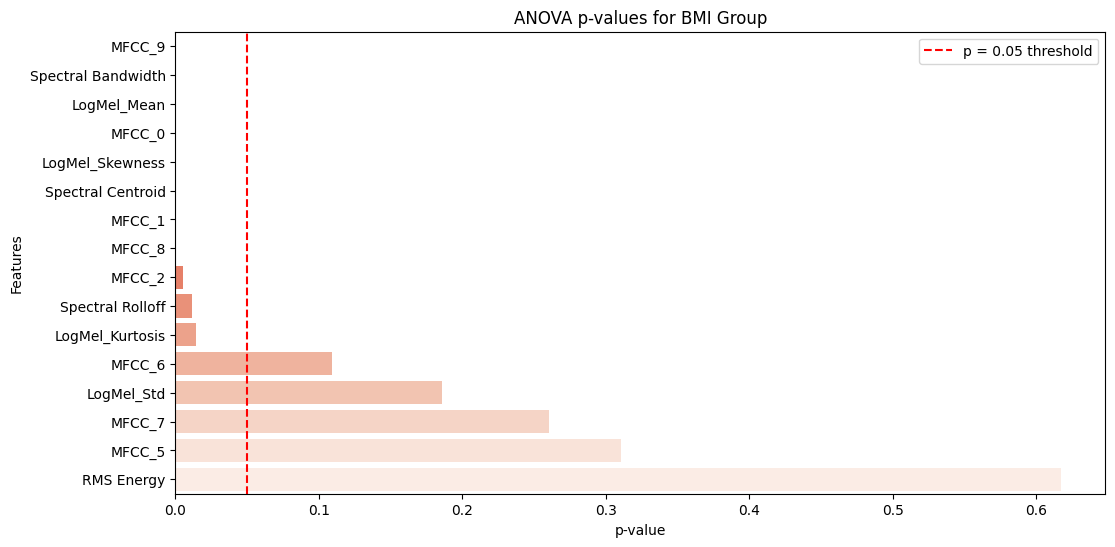

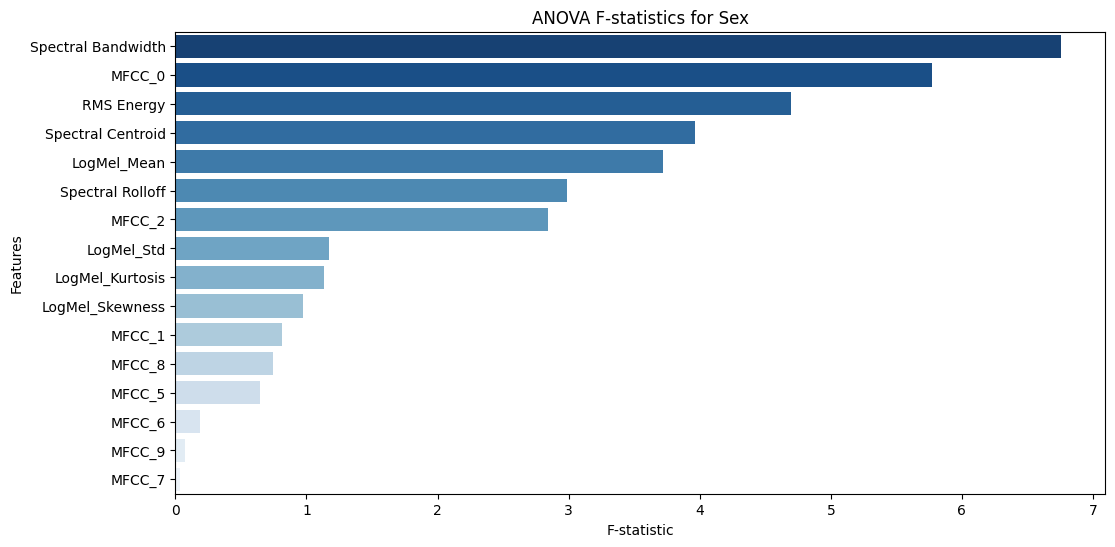

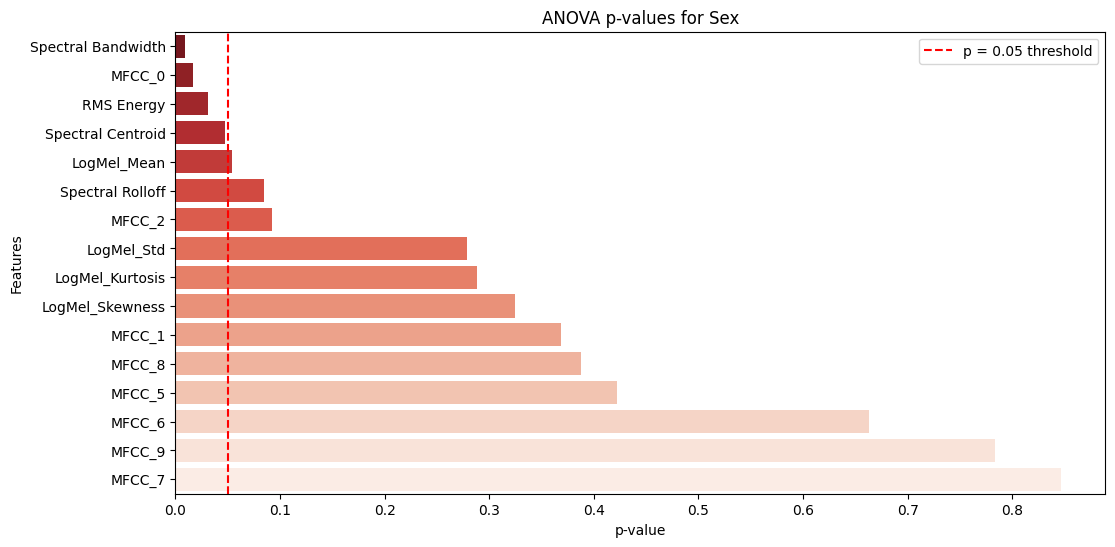

In [127]:
import scipy.stats as stats

def perform_anova(features_df, labels_df, domain_label):
    """Performs ANOVA to test for significant differences in feature distributions across domain labels.

    Args:
        features_df (pd.DataFrame): DataFrame containing numerical feature values.
        labels_df (pd.DataFrame): DataFrame containing categorical labels.
        domain_label (str): The specific label column to test for domain shifts.

    Returns:
        pd.DataFrame: ANOVA results with F-statistics and p-values for each feature.
    """
    anova_results = {}

    # Iterate through each feature in the dataset
    for feature in features_df.columns:
        # Group data by domain label
        grouped_data = [features_df[labels_df[domain_label] == category][feature]
                        for category in labels_df[domain_label].unique()
                        if category in labels_df[domain_label].values]

        # Perform ANOVA
        f_stat, p_value = stats.f_oneway(*grouped_data)

        # Store results
        anova_results[feature] = {"F-statistic": f_stat, "p-value": p_value}

    # Convert to DataFrame
    anova_df = pd.DataFrame(anova_results).T
    return anova_df

# Perform ANOVA for each domain factor
anova_results_recording_device = perform_anova(filtered_feature_matrix_V, labels, "Recording Device")
anova_results_age_group = perform_anova(filtered_feature_matrix_V, labels, "Age Group")
anova_results_bmi_group = perform_anova(filtered_feature_matrix_V, labels, "BMI Group")
anova_results_sex = perform_anova(filtered_feature_matrix_V, labels, "Sex")

# Function to visualize ANOVA results
def visualize_anova_results(anova_df, domain_label):
    """Visualizes the ANOVA results using bar plots for F-statistics and p-values.

    Args:
        anova_df (pd.DataFrame): DataFrame containing ANOVA F-statistics and p-values.
        domain_label (str): The specific domain label being analyzed.

    Returns:
        None: Displays bar plots.
    """
    # Sort features by F-statistic for better visualization
    anova_df_sorted = anova_df.sort_values(by="F-statistic", ascending=False)

    # Plot F-statistics
    plt.figure(figsize=(12, 6))
    sns.barplot(y=anova_df_sorted.index, x=anova_df_sorted["F-statistic"], palette="Blues_r")
    plt.xlabel("F-statistic")
    plt.ylabel("Features")
    plt.title(f"ANOVA F-statistics for {domain_label}")
    plt.show()

    # Plot p-values
    plt.figure(figsize=(12, 6))
    sns.barplot(y=anova_df_sorted.index, x=anova_df_sorted["p-value"], palette="Reds_r")
    plt.axvline(x=0.05, color="red", linestyle="--", label="p = 0.05 threshold")
    plt.xlabel("p-value")
    plt.ylabel("Features")
    plt.title(f"ANOVA p-values for {domain_label}")
    plt.legend()
    plt.show()

# Visualize ANOVA results
visualize_anova_results(anova_results_recording_device, "Recording Device")
visualize_anova_results(anova_results_age_group, "Age Group")
visualize_anova_results(anova_results_bmi_group, "BMI Group")
visualize_anova_results(anova_results_sex, "Sex")

**Strong domain shift**: Recording Device

Recording Device introduces the most severe domain shift, primarily affecting **LogMel** and **spectral** features.

**Moderate domain shift**: Age Group, BMI Group

Age and BMI introduce moderate shifts, influencing **MFCCs** and **spectral energy** features.

**Minimal domain shift**: Sex

Sex has minimal effect, meaning it is not a major source of bias in this dataset.